<a href="https://colab.research.google.com/github/winka9587/BundleTrack/blob/master/First.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 可能的修改方向

是否可以通过

$p_1=A_{12}A_{21}p_1$

让$A_{12}$$A_{21}$逼近单位矩阵$I$？

理想情况下是没有问题的，理想情况下，$p_1$与$p_2$中的每个点都能找到一个一一对应的点，因此$A_{21}p_1$能够完全拟合$p_2$，反过来$A_{12}p_2$能够完全拟合$p_1$。因此理想情况下等式是可以成立的。

但是实际使用中，因为存在不对应的点，所以感觉会有点问题。但是应该举个什么例子呢？我现在$A_{12}A_{21}$是结果，并不能说明问题。

应该将$p_1$中的点分为两部分来考虑，$p^{in}_{1}$和$p^{out}_{1}$分别指代有对应的点(inlier)和无对应的点(outlier)，对$p_2$来说也同样。

对于$p^{in}_{1}$来说，$A_{21}p^{in}_{1}$能够映射到$p^{in}_{2}$，但是对于$p^{out}_{1}$来说，$A_{21}p^{out}_{1}$无法成功映射到任何对应点。

CorrLoss是否能够引入颜色？因为原本的SPD中，是形状先验Shape Prior与重建的实例模型进行拟合，ShapePrior是无法包含颜色的。而我的则没有这个问题，因此颜色反而是优势。

<br><br>

---

目前看来$R,t$投影后的颜色才是突破口

1.加一个attention来筛选哪些特征能够匹配**（目的是训练一个网络能够识别哪些像素在NOCS下是重复的）**

2.引入RGB（and光度），使用HOG特征等？**（直接卷积）**

3.Loss添加对Color和Normal的约束（在NOCS空间中进行Loss的计算） 其实本质是添加 “$R$,$t$变换$p_1$之后，与$p_2$进行校准”的一个操作。是重要的。要么在迭代中这么做，要么在Loss中这么做。像是RPMNet，$p_1$与$p_2$进行匹配后，估计得到{$R$,$t$}。然后用$Rp_1+t$与$p_2$进行匹配。

如果按这个来，在之后的迭代中将无法使用卷积。或者说，卷积得到的特征不应该随着xyz的变化而改变。不需要进行卷积。

**迭代的过程要引入$R$,$t$,**

4.累计误差的问题其实并没有被完全克服，因为当固定了base之后，没有机制可以判断 估计的第n帧的位姿Pose投影后是否是准确的。例如base帧存在误差，那么之后的每一帧估计出来都会有误差。**(其实和3是一个问题)**

5.填充深度，可以网络训练，也可以简单填充。填充至RGB图像的边缘处即可

添加候选点(candicate points)，根据摄像头视线射线，生成候选点。但是有一个问题，候选点按道理来说是越多越好，如何让候选点尽可能多的同时，不过多占用1024个有限采样点？**(没有必要,match_feature不限制参与匹配的点)**

能否分开单独匹配？**(没有必要)**让候选点先匹配，然后让masked点云再去匹配。match_features的输入是

In [ ]:
def match_features(feat_src, feat_ref, metric='l2'):
    """ Compute pairwise distance between features

    Args:
        feat_src: (B, J, C)
        feat_ref: (B, K, C)
        metric: either 'angle' or 'l2' (squared euclidean)

    Returns:
        Matching matrix (B, J, K). i'th row describes how well the i'th point
         in the src agrees with every point in the ref.
    """

只需要确保特征维度C相同即可，最终会返回权重矩阵，需要注意此时的返回值是没有归一化的。其实另一边也没有限制点的数量：

In [ ]:
feat_src = self.feat_extractor(xyz_src, norm_src)  # (B,N,3)+(B,N,3) -> (B,N,96) # 提取特征[B, N=1024, D=96]
feat_ref = self.feat_extractor(xyz_ref, norm_ref)

**也就意味着，只需要记录好候选点在xyz_src和xyz_ref中的下标，就能够在match_features中将对应的权重分离出来。**

# Overlap_classify network

输入:depth,rgb,mask

输出:mask_overlap(标记哪些点是存在重叠的,哪些点是不重叠的,最好还能够标记深度缺失部分可能的候选点，这应该是另一个网络的事情？)

已有的标签: 已有nocs可以计算重叠,在图像上能够标记重叠点与非重叠点。

# Candicate point network

目的：从深度缺失的点中构建候选点，这些候选点可能有物体的点，也可能有背景点。

输入：rgb，depth，mask(膨胀)

输出：标记的候选点

# A的对应问题



*首先需要明确一点：位姿是一个相对的概念，我们所说的位姿其实是一个坐标系变换到另一个坐标系的位姿。单独一个坐标系是没有位姿可言的。*

## 问题与分析
在测试卫星的时候发现一个问题,提取相邻两帧的特征之后，通过$Ap_2$得到$p_1$在$p_2$坐标系下的映射点，进而可以通过$p_1$与$Ap_2$来求解位姿。然而！！！

问题出现:最开始发现问题是因为使用$p_1$与$p_2$求解ICP得到的位姿与使用$T_{gt2}T^{-1}_{gt1}$计算得到的两帧间位姿$T_{gt12}$不同，一开始我还怀疑是因为网络不工作导致的。



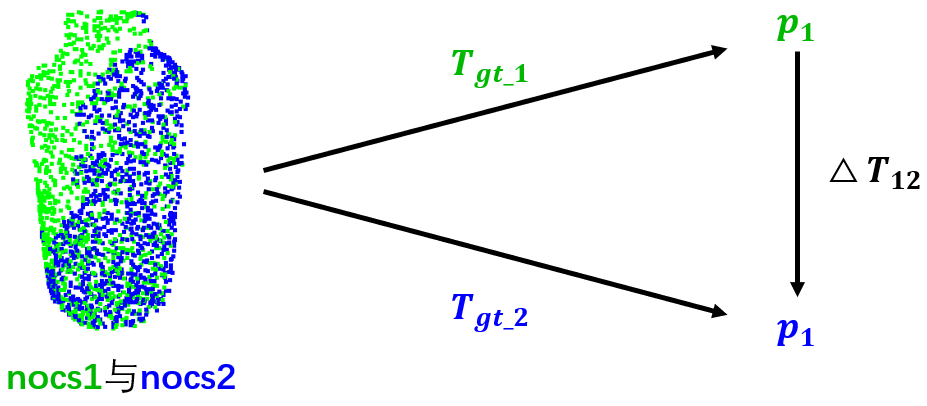

设想一下，$nocs1$与$nocs2$，同样可以使用$p_1$与$p_2$的特征相似度计算得到的对应矩阵$A$，$nocs1$与$A*nocs2$估计得到的位姿$\Delta T_{nocs}$其实是nocs1点云到nocs2点云自身的物体坐标系的变换。那既然如此，$p_1$和$p_2$之间用ICP估计出的位姿，肯定也有一个两坐标系之间的变换。

$p_1$与$p_2$使用ICP求解计算出的位姿$\Delta T_{1}$,其实包含了两个点云坐标系的变换$\Delta T_{nocs}$

因此：

$$T_{gt2}=\Delta T_{gt12} T_{gt1}$$

$$\Delta T_{gt12}=T_{gt2}T^{-1}_{gt1}$$

而$p_1$与$p_2$求解出的位姿$ΔT_{12}$

$$ΔT_{12}=T_{gt12}T_{nocs12}$$

因此，在相邻两帧进行位姿估计时，想要估计得到$ΔT_{gt12}$,还需要乘以$T_{nocs12}$的逆

$$T_{gt12}=ΔT_{12}T^{-1}_{nocs12}$$

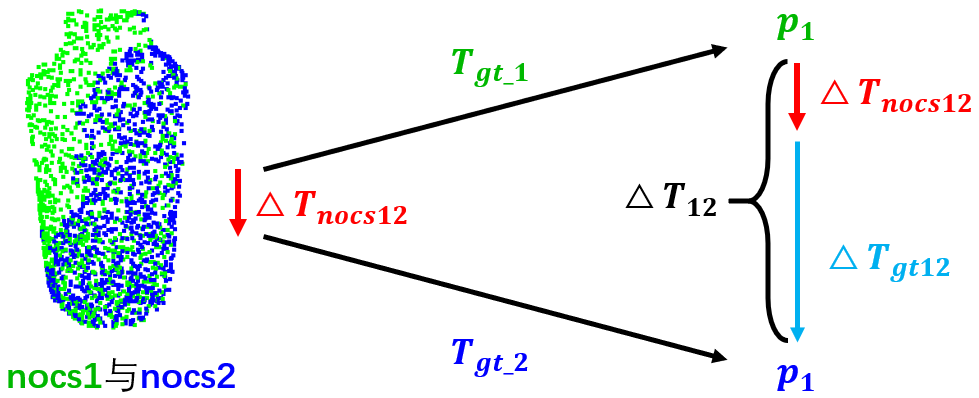

## 为什么这个问题现在会暴露出来？

可能是因为$T_{gt1}$和$T_{gt2}$的值过大,以前这两个变换的位移都非常小。现在能够从0.0xx变到1000.xxx。**那也不对**，$T_{gt}$并不会影响$ΔT_{nocs12}$的大小。

**当相机连续运动时，相邻两帧观测点云差异不会很大。**这是非常重要的一个假设。

唯一的可能：在sate数据集中,随着视角变换(时间戳前进)导致的点云变化增大，进而$A$匹配错误的点增多，导致$T_{nocs12}$误差增大到被发现的程度。

**是因为nocs1和nocs2距离太远，导致$ΔT_{nocs12}$的位移也很大。这是导致$p_1$与$p_2$拟合的变换$ΔT_{12}$与$nocs1$和$nocs2$拟合的变换$ΔT_{nocs12}$差异巨大的原因。
但是$ΔT_{12}$与$\Delta T_{gt12}$差异很大的原因是因为nocs坐标错误导致训练错误。**

In [ ]:
# 因为nocs1和nocs2的坐标值过大,导致T_nocs12的位移值非常大
nocs1
Out[27]:
tensor([[[    6.5113,  -252.4770, -1068.4019],
         [    6.5589,  -252.4779, -1068.4320],
         [    6.6797,  -252.4777, -1068.4515],
         ...,
         [    6.7325,  -252.0813, -1068.6525],
         [    6.7611,  -252.0811, -1068.6526],
         [    6.4239,  -252.0828, -1068.6532]]], device='cuda:0')
nocs2
Out[28]:
tensor([[[    1.4043,  -251.3660, -1068.7662],
         [    1.2563,  -251.3637, -1068.8011],
         [    1.2939,  -251.3638, -1068.8135],
         ...,
         [    1.4307,  -250.9671, -1069.1405],
         [    1.4826,  -250.9663, -1069.1400],
         [    1.1437,  -250.9689, -1069.1412]]], device='cuda:0')

transform_nocs12 = compute_rigid_transform(nocs1, torch.bmm(perm_matrix, nocs2),
                                                           weights=torch.sum(perm_matrix, dim=2))
transform_nocs12
Out[30]:
tensor([[[ 3.1217e-01, -4.6123e-01,  8.3060e-01,  7.7054e+02],
         [-6.8917e-01,  4.9200e-01,  5.3179e-01,  4.9836e+02],
         [-6.5410e-01, -7.3847e-01, -1.6423e-01, -1.2032e+03]]],
       device='cuda:0')


可视化发现两个nocs距离非常远，虽然通过$T_1$和$T_2$能够顺利投影到图像上，但是两个点云明显不属于同一个物体坐标系。

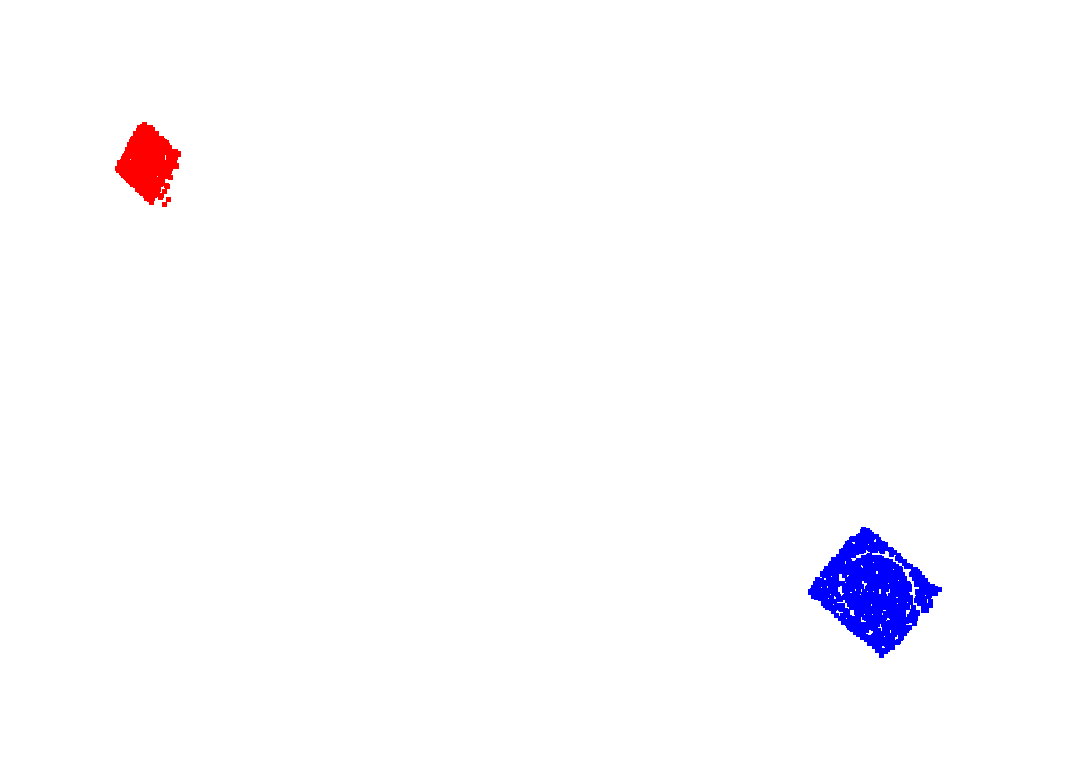

观测点云是没有问题的。

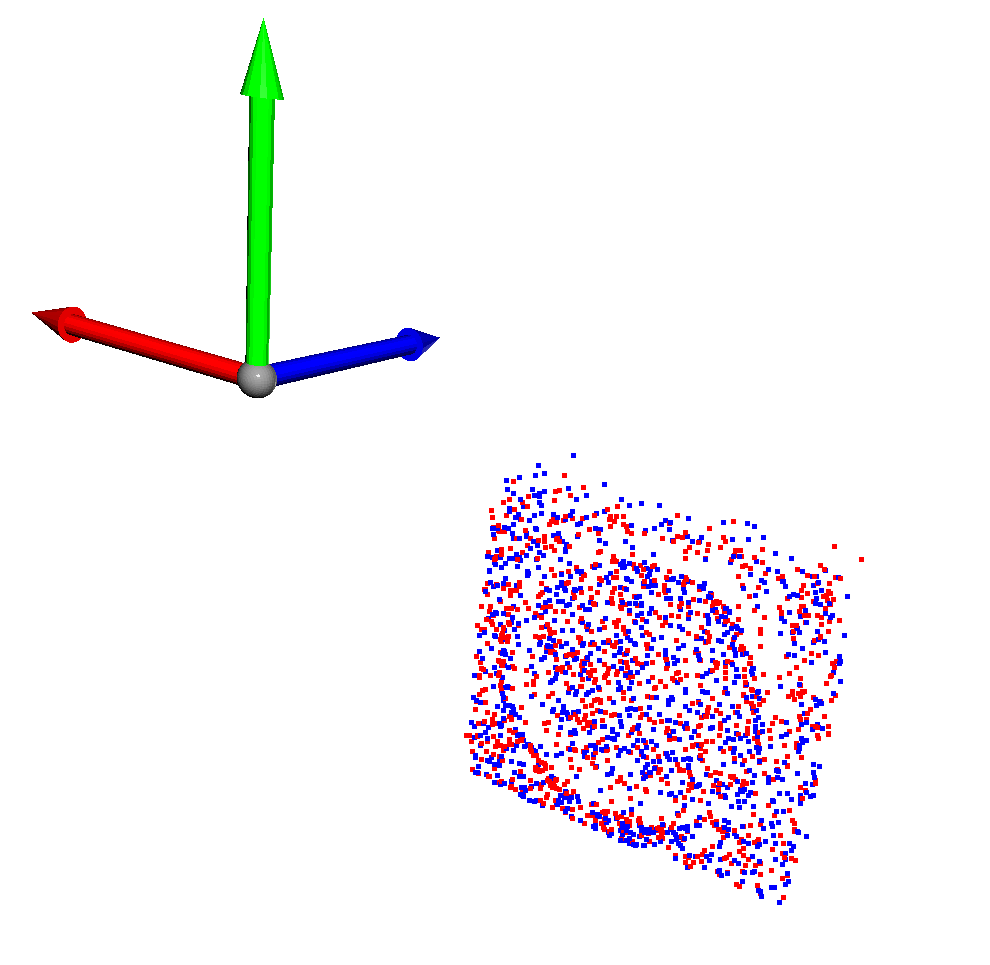

depth_render读取到的点云经过逆变换来得到物体坐标系下的点，这里出现了错误。读取的位姿应该没错。但是逆变换之后的点云错了。明天修改这里。





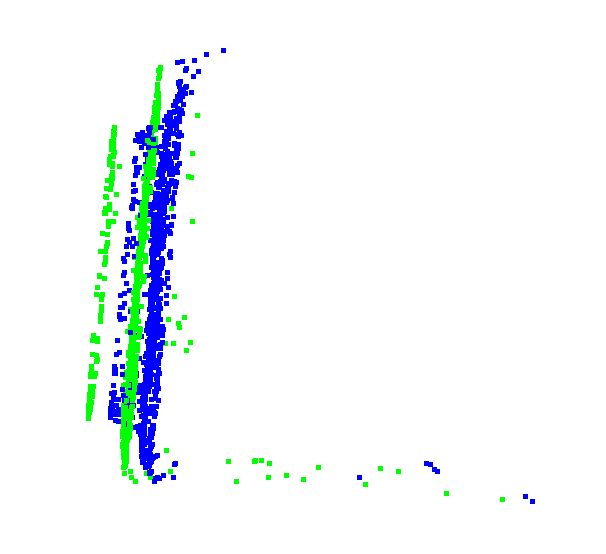

上图可以看到，depth_render与depth恢复的点云差异还挺大的。

**破案:depth和depth_render都不需要除以1000**

## 启发:新Loss

在实际的测试中，是无法得到$T_{nocs12}$的，因此需要想办法将利用$A*nocs2$与$nocs1$进行ICP求解出的位姿$T$必须为$\{I|0\}$。

努力的方向

限制$T_{nocs12}$为$\{I|0\}$，位姿$T_{nocs12}$是通过$p_1$与$p_2$在nocs下的映射$nocs1$与$nocs2$,结合权重矩阵$A$进行ICP求解得到的。

$$T_{nocs12}=ICP(f(A*nocs2),f(nocs1))$$

函数$f$筛选参与ICP求解的点

更进一步来说，(1)的本质是限制参与ICP计算的点，需要将ground truth对应的点挑选出来。自然而然地，$T_{nocs12}$就会是$\{I|0\}$

In [ ]:
transform_1_to_2 = compute_rigid_transform(points1, points_1_in_2, weights=torch.sum(perm_matrix, dim=2))

可以发现输入的权重矩阵weights按行进行求和(perm_matrix尚未进行归一化)

In [ ]:
def compute_rigid_transform(a: torch.Tensor, b: torch.Tensor, weights: torch.Tensor):
  """Compute rigid transforms between two point sets

  Args:
      a (torch.Tensor): (B, M, 3) points
      b (torch.Tensor): (B, N, 3) points
      weights (torch.Tensor): (B, M)

  Returns:
      Transform T (B, 3, 4) to get from a to b, i.e. T*a = b
  """

这里涉及到了weighted procrustes算法的实现问题，在RPMNet的一个[issue](https://https://github.com/yewzijian/RPMNet/issues/32)中有被提及。

具体理论可以学习[Orthogonal Procrustes problem](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem)

# RPMNet的刚性变换求解



感觉计算权重是否有些问题？为什么两个都乘以同一个权重？

问题在于没有公式，无法确定该实现是否有问题。

In [ ]:
  centroid_a = torch.sum(a * weights_normalized, dim=1)
  centroid_b = torch.sum(b * weights_normalized, dim=1)

In [ ]:
def compute_rigid_transform(a: torch.Tensor, b: torch.Tensor, weights: torch.Tensor):
  """Compute rigid transforms between two point sets

  Args:
      a (torch.Tensor): (B, M, 3) points
      b (torch.Tensor): (B, N, 3) points
      weights (torch.Tensor): (B, M)

  Returns:
      Transform T (B, 3, 4) to get from a to b, i.e. T*a = b
  """

  weights_normalized = weights[..., None] / (torch.sum(weights[..., None], dim=1, keepdim=True) + _EPS)
  centroid_a = torch.sum(a * weights_normalized, dim=1)
  centroid_b = torch.sum(b * weights_normalized, dim=1)
  a_centered = a - centroid_a[:, None, :]
  b_centered = b - centroid_b[:, None, :]
  cov = a_centered.transpose(-2, -1) @ (b_centered * weights_normalized)

  # Compute rotation using Kabsch algorithm. Will compute two copies with +/-V[:,:3]
  # and choose based on determinant to avoid flips
  u, s, v = torch.svd(cov, some=False, compute_uv=True)
  rot_mat_pos = v @ u.transpose(-1, -2)
  v_neg = v.clone()
  v_neg[:, :, 2] *= -1
  rot_mat_neg = v_neg @ u.transpose(-1, -2)
  rot_mat = torch.where(torch.det(rot_mat_pos)[:, None, None] > 0, rot_mat_pos, rot_mat_neg)
  assert torch.all(torch.det(rot_mat) > 0)

  # Compute translation (uncenter centroid)
  translation = -rot_mat @ centroid_a[:, :, None] + centroid_b[:, :, None]

  transform = torch.cat((rot_mat, translation), dim=2)
  return transform

# RPMNet的alpha与beta

In [ ]:
feat_distance
Out[9]:
tensor([[[0.1090, 0.2432, 0.0838,  ..., 1.9939, 2.0932, 2.1171],
         [0.0582, 0.2052, 0.0410,  ..., 2.1495, 2.2372, 2.2228],
         [0.0271, 0.0308, 0.0892,  ..., 2.0166, 2.1759, 2.1686],
         ...,
         [2.3139, 2.3354, 2.3823,  ..., 0.1514, 0.0598, 0.0517],
         [2.1100, 2.1240, 2.1933,  ..., 0.0625, 0.0277, 0.0451],
         [2.1934, 2.2029, 2.2712,  ..., 0.0660, 0.0313, 0.0604]]],
       device='cuda:0')
affinity
Out[10]:
tensor([[[ -3.6211,  -8.0763,  -2.7825,  ..., -66.2194, -69.5193, -70.3129],
         [ -1.9315,  -6.8146,  -1.3610,  ..., -71.3882, -74.3019, -73.8240],
         [ -0.9014,  -1.0216,  -2.9640,  ..., -66.9753, -72.2667, -72.0214],
         ...,
         [-76.8491, -77.5622, -79.1201,  ...,  -5.0272,  -1.9856,  -1.7160],
         [-70.0772, -70.5431, -72.8437,  ...,  -2.0745,  -0.9215,  -1.4994],
         [-72.8449, -73.1606, -75.4310,  ...,  -2.1934,  -1.0398,  -2.0076]]],
       device='cuda:0')
alpha
Out[11]: tensor([2.4818e-08], device='cuda:0')
beta
Out[12]: tensor([33.2117], device='cuda:0')

In [ ]:
def compute_affinity(self, beta, feat_distance, alpha=0.5):
  """Compute logarithm of Initial match matrix values, i.e. log(m_jk)"""
  if isinstance(alpha, float):
      hybrid_affinity = -beta[:, None, None] * (feat_distance - alpha)
  else:
      hybrid_affinity = -beta[:, None, None] * (feat_distance - alpha[:, None, None])
  return hybrid_affinity

可以发现$α$的值接近于0，对比代码中，传统方法手动设定$α$默认值是0.5，说明其没有起到过滤outlier点的作用。

鼓励feat_distance小于$α$，此时两者差的值小于0，进而乘以$-\beta$后会得到一个正值，计算$e^x$之后权重会更大。

另一方面，$β$的值非常大, 说明feat_distance大的点对其绝对值更大，取负之后的对数结果更小。

# base frame match with current frame

当base frame开始匹配时, 我们基于的假设是, 此时的base frame与current frame有一定的重叠，当重叠大到一定的程度时，需要更新base frame

那么基于该假设的条件下，需要预测

# CorrLoss可能的修改

在perm_matrix阶段就应该开始删除点对，因为有的行可能perm_matrix每个值都非常小。经过归一化变成corr_matrix之后，一群小的点反而将权重给平分了。不能反应问题。

>*物体的观测点云是局部的，观测点云在互相匹配时不可避免地要面对这个问题：必须区分哪些点是有对应的，哪些点是没有对应的。而在观测点云与完整模型进行匹配时则更简单一点，因为观测点云的每一个点都在模型上有所对应。*

原本，我的$CorrLoss=A*nocs2-nocs1$，其在最初的使用场合是$A(M_c+D)-M_o$，通过对先验模型$M$进行变形，使其逼近局部观测点云。需要注意：形状先验$M_c$和实例模型的观测结果$M_o$都在NOCS坐标系下。也就是说:$CorrLoss$中$A$和$D$的作用是约束两个模型的形状。

In [ ]:
  """
  Args:
      assign_mat: bs x n_pts x nv
      deltas: bs x nv x 3
      prior: bs x nv x 3
  """
  inst_shape = prior + deltas
  # smooth L1 loss for correspondences
  soft_assign = F.softmax(assign_mat, dim=2)
  coords = torch.bmm(soft_assign, inst_shape)  # bs x n_pts x 3
  diff = torch.abs(coords - nocs)
  less = torch.pow(diff, 2) / (2.0 * self.threshold)
  higher = diff - self.threshold / 2.0
  corr_loss = torch.where(diff > self.threshold, higher, less)
  corr_loss = torch.mean(torch.sum(corr_loss, dim=2))
  corr_loss = self.corr_wt * corr_loss

## 训练相邻两帧

在训练相邻两帧时，考虑两帧差异应该更少.

### 引入color

(1)在提取颜色特征不再使用原本的point_color,而是使用卷积提取2D图像的局部颜色特征，赋给单独的点。
(2)颜色如何引入校准，要么在Loss中使用，要么在

# two keypoint

## 1.How dose RPMNet mark outlier when compute pose（解决）

>*Since not every point $x_j$ might have a correspondence, we weigh each correspondence $(x_j,\hat{y}_j)$ by $w_j =\sum_{k}^{K}m_{jk}$ when computing the rigid transformation.*



RPMNet通过对对应矩阵的行求和，来获得$X$中的点$x_i$与$Y$中所有点的权重，但是$m_{jk}$是否是softmax之后的结果？

**不是，但是log_perm_matrix是使用了对数归一化的结果**，使用的权重矩阵是取对数的perm_matrix,每个位置的权重均为正值。其认为不存在匹配的点(例如下标是j)，将$X$中的$x_j$与$A*Y$中的$y_j$点都乘以权重和$w_j$，使其对最终估计的$pose$的影响降低。

In [ ]:
log_perm_matrix = sinkhorn(affinity, n_iters=self.num_sk_iter, slack=self.add_slack)
perm_matrix = torch.exp(log_perm_matrix)
weighted_ref = perm_matrix @ xyz_ref / (torch.sum(perm_matrix, dim=2, keepdim=True) + _EPS)

# Compute transform and transform points
transform = compute_rigid_transform(xyz_src, weighted_ref, weights=torch.sum(perm_matrix, dim=2))

测试了直接不重新训练，在网络中直接修改$α$的值为0.5，得到的结果perm_matrix2与原本的$\alpha=0.0$得到的结果perm_matrix.

结果有些让人疑惑，当$\alpha$的值被调大之后，经过sinkhorn的双随机操作，perm_matrix2每行的权重和相比于之前大大增大了。是否是因为在归一化时，权重的取值范围变大了导致的？

In [ ]:
perm_matrix
Out[33]:
tensor([[[7.8053e-04, 3.1348e-02, 9.7128e-03,  ..., 9.7927e-28,
          2.5516e-24, 6.3077e-24],
         [1.3324e-04, 5.5461e-02, 5.8009e-02,  ..., 7.1643e-28,
          5.5280e-25, 3.5263e-26],
         [1.6057e-04, 5.0001e-02, 5.3037e-02,  ..., 6.2776e-28,
          4.3247e-25, 2.4833e-26],
         ...,
         [1.0709e-25, 1.4158e-24, 4.3486e-25,  ..., 3.6161e-09,
          4.7209e-05, 3.5932e-05],
         [7.3240e-26, 3.7824e-25, 1.6173e-25,  ..., 7.9065e-02,
          1.3606e-01, 5.7507e-12],
         [1.1859e-26, 1.1165e-24, 1.3730e-25,  ..., 6.0724e-11,
          2.2979e-07, 2.7921e-02]]], device='cuda:0')
perm_matrix2
Out[34]:
tensor([[[4.9671e-02, 3.9358e-01, 1.5679e-01,  ..., 2.3601e-26,
          4.9005e-23, 1.1208e-22],
         [2.6458e-03, 2.1728e-01, 2.9220e-01,  ..., 5.3878e-27,
          3.3128e-24, 1.9552e-25],
         [3.3897e-03, 2.0825e-01, 2.8401e-01,  ..., 5.0187e-27,
          2.7552e-24, 1.4637e-25],
         ...,
         [7.6955e-25, 2.0072e-24, 7.9266e-25,  ..., 9.8404e-09,
          1.0237e-04, 7.2092e-05],
         [5.0313e-25, 5.1264e-25, 2.8183e-25,  ..., 2.0569e-01,
          2.8208e-01, 1.1030e-11],
         [4.3908e-25, 8.1560e-24, 1.2895e-24,  ..., 8.5147e-10,
          2.5676e-06, 2.8865e-01]]], device='cuda:0')

## 2.How does CMU get Match_matrix_gt（解决）

经过定位,对应矩阵的ground truth是通过[ComputeCorrMat](https://github.com/tzodge/PCR-CMU/blob/6ddfc78bf0ee2638e2c512e905edb2d0eb0d89ee/RPMNet_Code/src/data_loader/transforms.py#L372)类计算得到的。

In [ ]:
class ComputeCorrMat:
  """Computes GroundTruth Correspondence Matrix"""
  def __call__(self, sample):

      src = sample['points_src'][:,:3]
      ref = sample['points_ref'][:,:3]

      inl_threshold = 0.1 # threshold to decide whether a point is an inlier
      out_threshold = inl_threshold*2 # threshold to decide whether a point is an outlier

      # mutual Nearest-Neighbor search
      nn_search = NearestNeighbors(n_neighbors=1,metric='minkowski', p=2)
      nn_search.fit(ref)
      nndist1, nnidx1 = nn_search.kneighbors(X=src, n_neighbors=1, return_distance=True)
      nndist1=nndist1[:,0]
      nnidx1=nnidx1[:,0]

      nn_search = NearestNeighbors(n_neighbors=1,metric='minkowski', p=2)
      nn_search.fit(src)
      nndist2, nnidx2 = nn_search.kneighbors(X=ref, n_neighbors=1, return_distance=True)
      nndist2=nndist2[:,0]
      nnidx2=nnidx2[:,0]

      pc1_mnn_mask = np.take(nnidx2,nnidx1) == np.arange(nnidx1.shape[0])   # mutual NN mask
      corr_mat = np.zeros((nnidx1.shape[0],nnidx2.shape[0]),dtype=np.int64)
      corr_mat[np.arange(nnidx1.shape[0]),nnidx1] = 1  # set ones
      corr_mat[~pc1_mnn_mask,:] = 0   # if not mutual, set zero
      inlier_mask = nndist1 < inl_threshold
      corr_mat[~inlier_mask,:] = 0    # if not inlier, set zero

      assert (np.sum(corr_mat,axis=1).max() <=1) # assert one-to-one relationship
      assert (np.sum(corr_mat,axis=0).max() <=1)
  ###########################################################################################################

      sample['corr_mat'] = corr_mat.astype(np.float32)

      return sample

其具体操作便是使用最近邻搜索来寻找每个点的最近点，判定inlier和outlier的权重都是超参数。

可以使用nocs来测试一下该代码的有效性。输入点云为nocs1和nocs2,检查其寻找的对应关系能否使得Umeyama算法计算出的pose为{I|0}。

需要注意的是，这里使用的是hard-correspondence，用来监督可能会有影响。如果能用一个encoder-decoder结构将其转换为软对应，那么监督可能会更有效。而且可以与该论文的实验进行比较，比较起来也会很方便，只需要为该类别增加一个替换的函数即可。

In [ ]:
# 归一化之前
loss_value = -torch.sum(gt_cmat * torch.log(perm_matrix + 1e-8),dim=[-1, -2]) / (torch.sum(gt_cmat, dim=[-1, -2]) + 1e-8)
loss_value
Out[21]: tensor([7.1043], device='cuda:0')

# 归一化之后
gt_cmat = gt_cmat.cuda()
loss_value = -torch.sum(gt_cmat * torch.log(corr_matrix + 1e-8),dim=[-1, -2]) / (torch.sum(gt_cmat, dim=[-1, -2]) + 1e-8)
loss_value
Out[17]: tensor([6.9211], device='cuda:0')

# perm_matrix与corr_matrix相差仅有一个行归一化操作
# corr_matrix = perm_matrix / (torch.sum(perm_matrix, dim=2, keepdim=True) + _EPS)
# 但是最终的Loss却不一样？
# 可能会出现这种情况，因为原本的代码是为归一化之后的cmat设计的

## 3.能否使用encoder-decoder结构来生成更容易收敛的gt_corr_matrix？

这篇点云上采样的论文，其中有几张图关于点之间的互相影响关系
[Point Cloud Upsampling via Perturbation Learning](https://www.hznu.edu.cn/upload/resources/file/2022/03/01/7700945.pdf)

### 3.1 gt_corr_matrix所要具备的属性

#### 3.1.1 在NOCS下通过该对应计算得到位姿变换是$\{I|0\}$

#### 3.1.2 软对应

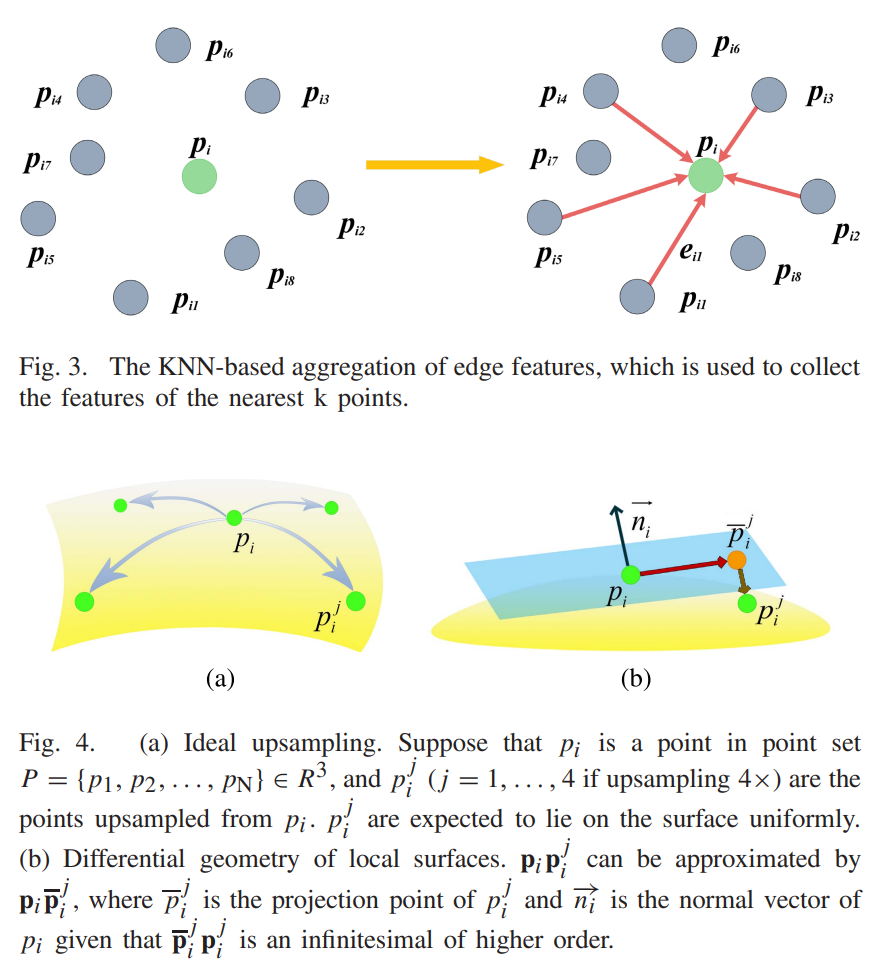

## 测试gt_corr_matrix估计位姿的效果

## 优缺点分析

优点：能够直接约束A，而非间接约束A。（可微or not？）我记得RPMNet里面说过求解位姿这个过程是可微的。

缺点：每次都需要使用时计算，因为A是两帧之间的。因此如果不能提前知道要和哪一帧进行配准，就无法提前准备A。

## 能否将直接约束A的思想推广到BA这个阶段？

BA相当于通过"project"来调整优化位姿$Pose$，能否通过投影来直接调整A?然后用A将所有帧串起来重建模型？

下图中其实有三个点云，但是蓝色与黄色重叠在了一起。结合计算出的nocs下位姿变换gt_transform，发现其值接近于$\{I|0\}$，因此可以大致判定：该方法计算得到的对应矩阵作为gt应该没有什么问题。而且$src$中没有对应的点也能正确分配权重（行的权重和为0）。

In [ ]:
gt_mat = ccm(nocs_base.squeeze(0).cpu().numpy(), nocs2.squeeze(0).cpu().numpy(), 0.1)
coords = torch.bmm(torch.from_numpy(gt_mat).unsqueeze(0).cuda(), nocs2)
gt_transform = compute_rigid_transform(nocs_base, coords, weights=torch.sum(torch.from_numpy(gt_mat).unsqueeze(0).cuda(), dim=2))
nocsbaseto2 = se3.transform(gt_transform.detach(), nocs_base)
gt_transform
Out[58]:
tensor([[[ 1.0001e+00, -4.1558e-04, -2.8481e-04,  1.7503e-03],
         [ 4.1848e-04,  9.9976e-01,  1.0644e-03,  2.0928e-04],
         [ 4.8478e-04, -1.0470e-03,  9.9989e-01,  1.6529e-03]]],
       device='cuda:0')
viz_points_diff_color(
    "nocs_base(red), nocsbaseto2 (green), nocs2 (blue)",
    [nocs_base.squeeze(0).cpu().numpy(), nocsbaseto2.squeeze(0).cpu().numpy(), nocs2.squeeze(0).cpu().numpy()],
    [np.array([255, 20,0]), np.array([0, 255, 20]), np.array([0, 0, 255])])

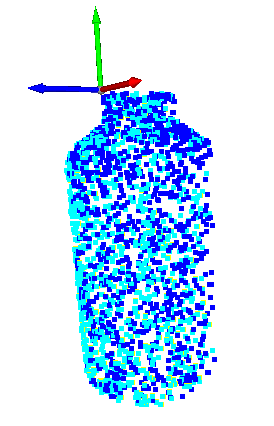

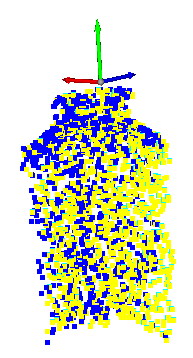

## weighted_corr_loss

使用weighted_Umeyama相同的思路，通过torch.sum(perm_matrix)对左右两边的点分配权重。相当于对点对进行加权，使得权重低的点对影响降低。

这一思路能够起作用的前提是，计算得到的perm_matrix要能够正确反映特征的相似度。也就是要求feature_extraction模块必须确保是工作的。

# weighted distance Loss效果有限（并非效果有限，而是发挥了反作用，需要阈值来切割权重小到可以忽视的点，让其完全无法发挥作用，或者只选权重top几个点）

## wd_loss可能存在的问题

In [ ]:
wd_loss_wrong = weighted_euclidean_distance(nocs1, coords, cmat2)
wd_loss_wrong
Out[11]: tensor(0.1259, device='cuda:0')

wd_loss = weighted_euclidean_distance(nocs2, coords, cmat2)
wd_loss
Out[9]: tensor(0.0725, device='cuda:0')

# 原本方法(错误实现)
wd_loss_wrong = weighted_euclidean_distance(nocs1[:, :], coords[:, focus_index].unsqueeze(1), cmat2[:, focus_index, :].unsqueeze(1))
wd_loss_wrong
Out[38]: tensor(0.0949, device='cuda:0')

# 原本方法
wd_loss_origin = weighted_euclidean_distance(nocs2[:, :], coords[:, focus_index].unsqueeze(1), cmat2[:, focus_index, :].unsqueeze(1))
wd_loss_origin
Out[31]: tensor(0.0953, device='cuda:0')

# 均值划分
wd_loss_mean = weighted_euclidean_distance(nocs2[:, idx], coords[:, focus_index].unsqueeze(1), cmat2[:, focus_index, idx].unsqueeze(1))
wd_loss_mean
Out[33]: tensor(0.0914, device='cuda:0')

# top-k划分
k = 10  # 使用topk
idx = torch.sort(A[focus_index])[1][-10:]
wd_loss_topk = weighted_euclidean_distance(nocs2[:, idx], coords[:, focus_index].unsqueeze(1), cmat2[:, focus_index, idx].unsqueeze(1))
wd_loss_topk
Out[36]: tensor(0.0741, device='cuda:0')

上面为三次对比实验，此前的训练过程中，wd_loss存在bug, 应该是$nocs2$与$A*nocs2$计算wd_loss，但是错误地使用了$nocs1$与$A*nocs2$来计算，使得wd_loss偏大且无法达到目标。

可以发现，均值划分和原本方法差异不大，说明一个问题，wd_loss是由着wd_loss主导的，并且因为均值不是0，因此无法正确地收敛。能否使用gt_CorrMatrix来获得一个wd的正确值？

# 可以利用T_gt*nocs来和观测点云训练深度缺失与拖尾

## 拖尾

nocs是必定没有拖尾存在的，因此可以利用这一点来训练拖尾去除。

# BA问题

## BA原理

# 直接约束corr_matrix

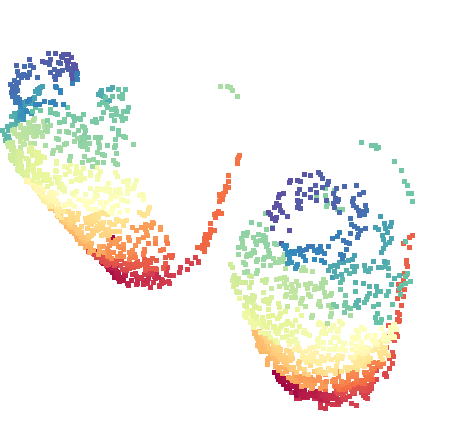

可以看到相邻帧之间处理的不错

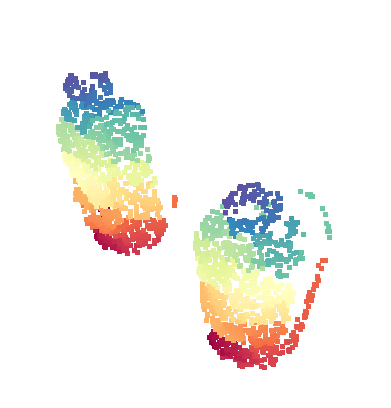

base帧和cur帧之间也能正常地进行特征匹配，目前还没有完全收敛，当前的使用的是707_1_gt_corr_color，gt_corr_loss还维持在7，还没有收敛到0

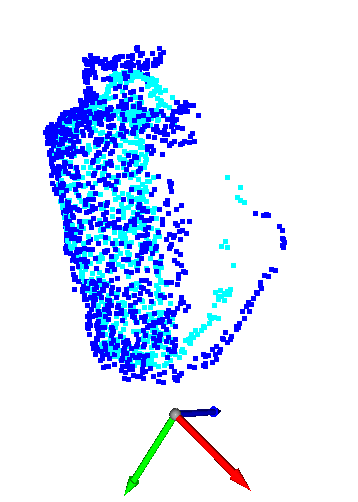

其仍然还有$A*pts2$之后缩小的情况, 但令人惊喜的是下图，base因为是经过crop的，所以拖尾很短，而网络估计的A，在与pts2计算$A*pts2$后就是拖尾很短的。

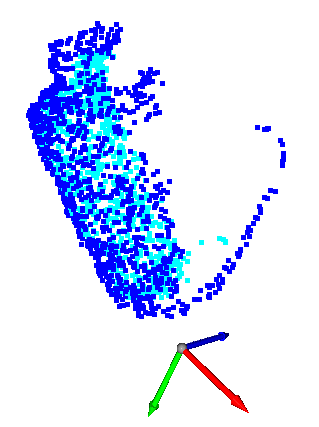

上图为base与cur的对应矩阵A2，乘以cur点云后的结果

## 1.乘以A之后缩小的问题

能否先按平均权重计算中心点，然后计算$pts2$与中心点的向量，将$A*pts2$之后的点沿着向量的方向放大。

测试：将base使用第二次估计的位姿变换过来，然后与$A*pts2$比较一下大小。

### 实验1. 将corr_matrix按行进行最大池化

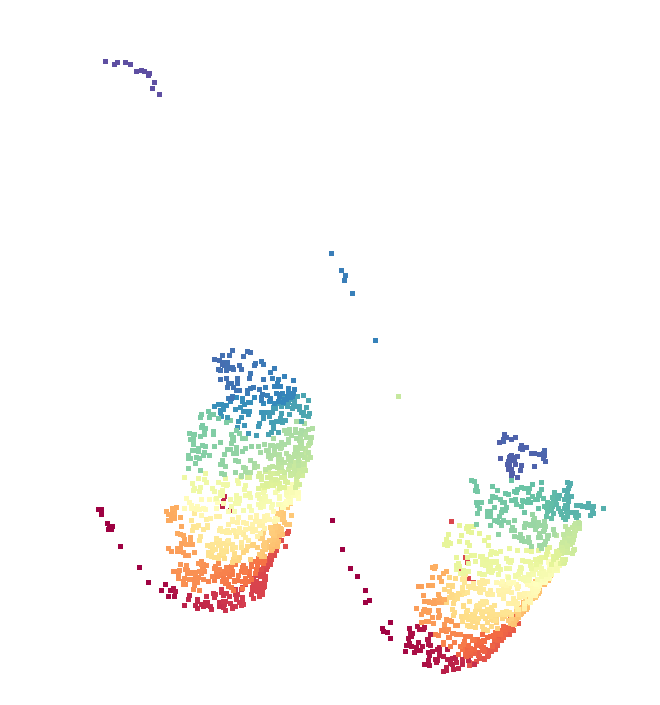

测试帧为第10帧,上图为base与cur的TSNE图像。

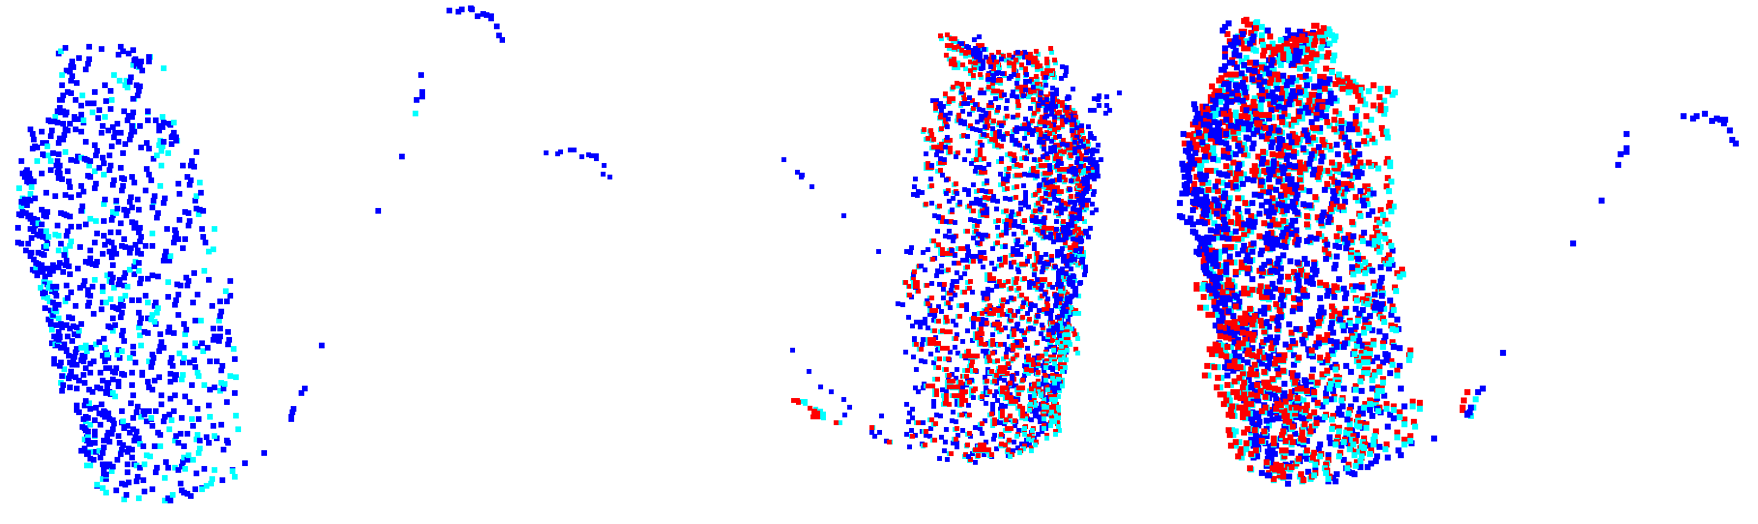

左图:对网络估计出的A每行进行最大池化。针对对应矩阵的每一行，选择权重最大的点将其权重置为1，其他点权重置为0.(深蓝色为pts2,浅蓝色为A*pts2)

点的数量明显变少，因为大量的点权重分配到同一个点上。而且神奇的是，最大池化的结果与原本的差不多。（右图，红色为原本网络估计的变换$T_{previous}$变换后的base, 浅蓝色为"行最大池化"后计算得到的位姿$T_{max_pool}$变换的base，深蓝色为pts2）

进行如下测试，可以发现，最终分配到每个点的权重，几乎都是一样的，不使用perm_matrix是不是也一样？

In [ ]:
ww = torch.sum(points_shuffle_base['perm_matrix'],dim=2, keepdim=True)
ww
Out[8]:
tensor([[[0.7423],
         [0.7349],
         [0.7524],
         ...,
         [0.8639],
         [0.7054],
         [0.8679]]], device='cuda:0')
ww.max()
Out[9]: tensor(0.9293, device='cuda:0')
ww.min()
Out[10]: tensor(0.6670, device='cuda:0')
ww.mean()
Out[11]: tensor(0.7991, device='cuda:0')


_EPS = 1e-5
ww_normalized = ww[..., None] / (torch.sum(ww[..., None], dim=1, keepdim=True) + _EPS)
ww_normalized
Out[15]:
tensor([[[[0.0009]],
         [[0.0009]],
         [[0.0009]],
         ...,
         [[0.0011]],
         [[0.0009]],
         [[0.0011]]]], device='cuda:0')


测试一个单位矩阵来作为perm_matrix,

In [ ]:
ee = torch.eye(1024).unsqueeze(0).cuda()
ee
Out[18]:
tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]], device='cuda:0')
ee.shape
Out[19]: torch.Size([1, 1024, 1024])
wwe = torch.sum(ee,dim=2, keepdim=True)
wwe_normalized = wwe[..., None] / (torch.sum(wwe[..., None], dim=1, keepdim=True) + _EPS)
wwe_normalized
Out[22]:
tensor([[[[0.0010]],
         [[0.0010]],
         [[0.0010]],
         ...,
         [[0.0010]],
         [[0.0010]],
         [[0.0010]]]], device='cuda:0')


### 分析

A导致点云缩小的原因是因为权重分散到多个点上，需要想办法将权重集中到尽量少的点上。之前的交叉熵损失或许目标就是这种问题？但是似乎效果并不好。对比一个gt_corr_matrix与实际最终收敛网络估计的结果。

**encoder-decoder结构来找到一个更加容易收敛的gt？**

nn最近邻方法可以作为一个初值，但是其并不一定是最好的。

## 2.base偏转的问题

### 问题现象

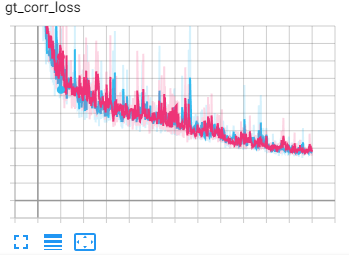

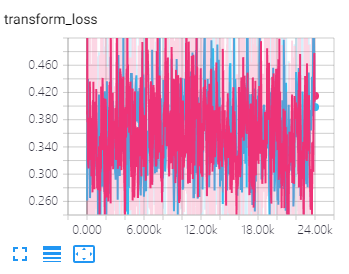

可以看到，虽然gt_corr_loss下降得很流畅，但是transform_loss却根本没有收敛，

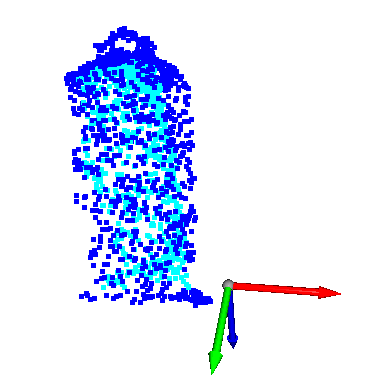

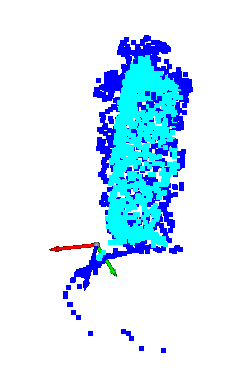

如上图所示，base帧经过相邻帧的估计位姿的变换之后，是倾斜的，这就导致其在和cur匹配时，被认为两者在同一个水平面上，导致最后A生成的base帧映射也是倾斜的。这个其实是旋转$Rotation$不准确的主要原因。能否解决这个问题？

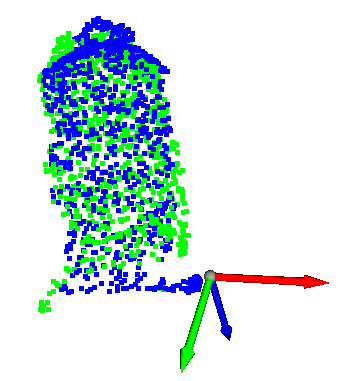

base帧与cur帧输入如图。是否是因为在nocs下训练导致的结果？可是提取特征是在相机坐标系下发生的。为什么会假定两者都在一个水平面？而且我是直接约束的gt_corr，理论上应该与位姿无关才对。

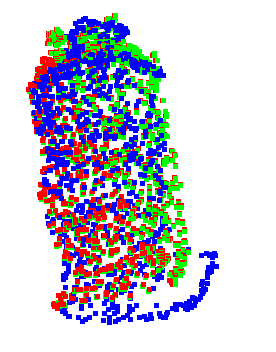

那为什么base还要变换？base变换应当只有投影的作用。base直接与cur应该也差不多？

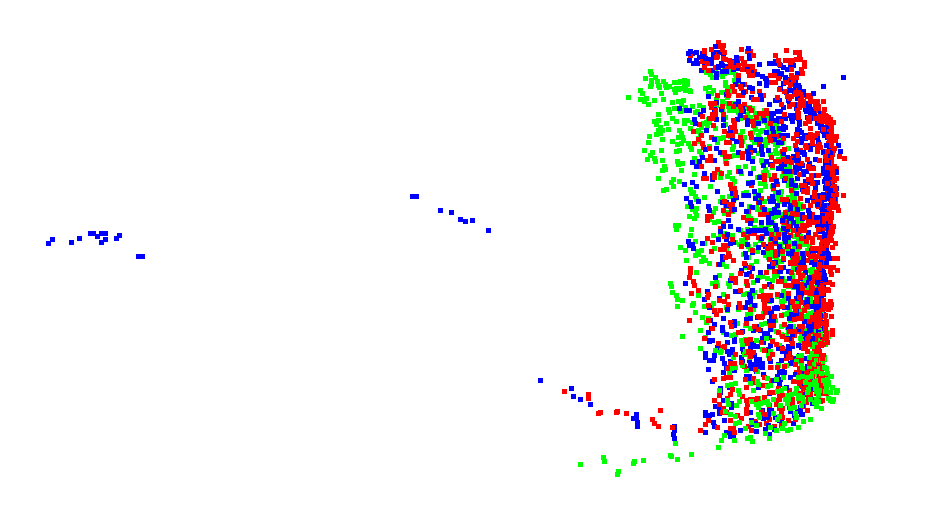

红色:base，蓝色：cur，绿色：T02@base,三个点云都是均值化后的结果。对比上上张图像，可以发现，红色和绿色点云的旋转并没有过于影响最终的结果。

### 测试寻找原因

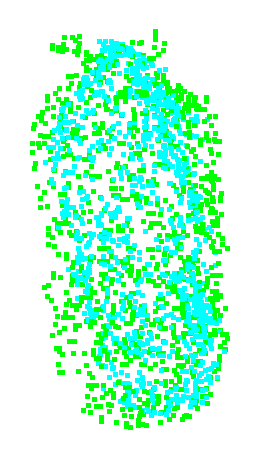

浅蓝色为%A*pts2%, 绿色为base通过第二轮变换过来的结果，发现两者其实也是倾斜的。

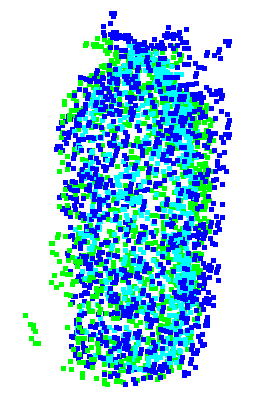

深蓝色为cur，也就是%pts2%，可以发现，base变换过来之后大部分还是与浅蓝色一致，但是没能完全变换成浅蓝色的样子。

**所以浅蓝色到底在映射谁？**

如果我将base移动到右边，它是否会向右边倾斜？

对比可以发现，在相邻两帧的估计上，cmat1中有明显的较大值，而到了cmat2上，则不是很明显。说明在训练的过程中，网络更专注于两帧的情况，是否是因为扰动不够明显？可视化一下扰动前后的点云。

In [ ]:
cmat2.max()
Out[6]: tensor(0.1519, device='cuda:0')
cmat2.min()
Out[7]: tensor(6.8586e-16, device='cuda:0')
cmat1.max()
Out[8]: tensor(0.6686, device='cuda:0')
cmat1.min()
Out[9]: tensor(4.2677e-16, device='cuda:0')

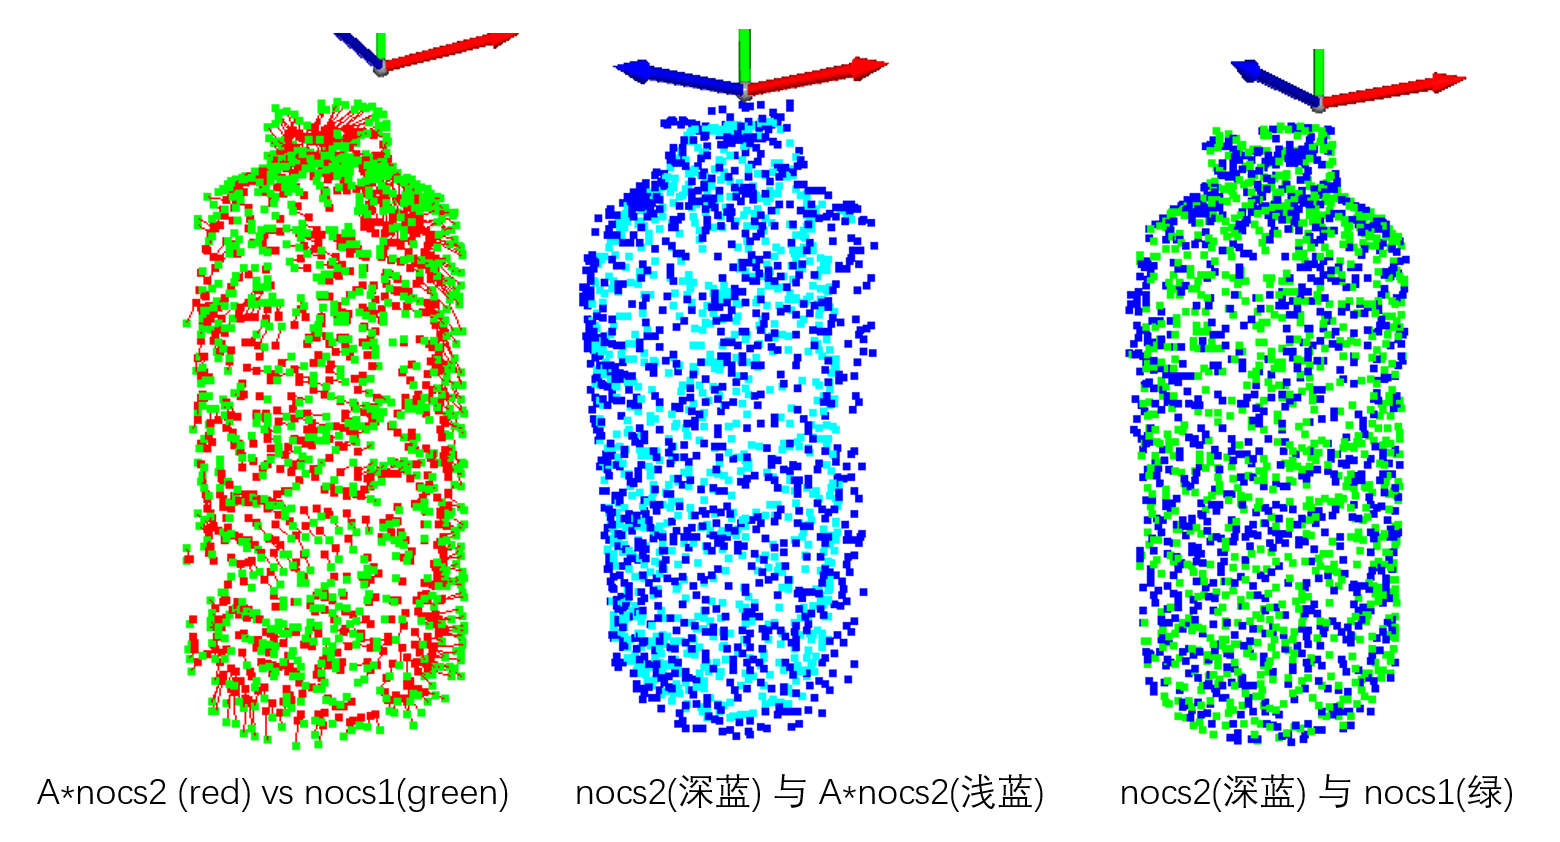

上图为A缩小问题

## 3.既然都是序列不定长，能否用attention的机制来对Corr做BA？

## 4.测试与传统方法(如ICP)的差异

[Stack Overflow](https://stackoverflow.com/questions/20120384/iterative-closest-point-icp-implementation-on-python)上的多个ICP实现，测试比较"base与cur"的ICP结果与网络结果，考虑能否用传统方法来修改。

[github上的一个实现](https://github.com/agnivsen/icp)

## 5.测试使用ssc去除拖尾

发现一个小bug，当前使用的特征是nrm，但是transform_base_to_2_normal与transform_base_to_2的结果却相差巨大。按理来说它们两个的值应该是相同的。

(解决) 忘了加

In [ ]:
with torch.no_grad():
    logger.info("start eval")
    estimator1.eval()
    estimator2.eval() # 忘了加

In [ ]:
# 使用nrm
cmat2_normal, transform_base_to_2_normal, points_base_to_2_normal, points_shuffle_base_normal = \
    estimator(data_base_normal, data2, use_filter=net2_use_filter)

# 使用color训练
if opt.m2_feat == 'nrm':
    cmat2, transform_base_to_2, points_base_to_2, points_shuffle_base = \
        estimator2(data_base_normal, data2, use_filter=net2_use_filter)
if opt.m2_feat == 'color':
    cmat2, transform_base_to_2, points_base_to_2, points_shuffle_base = \
        estimator2(data_base_color, data2_color_, use_filter=net2_use_filter)

...

pose_pred_dict_final_2frame_color = multiPoseDict(transform_base_to_2, transform_iter1)  # 最终估计的两帧间位姿
pose_pred_dict_final_color = transform_Dict([transform_base_to_2, transform_iter1, last_frame['pose_dict']])

# T_delta * T_pred12 * last_frame.T
pose_pred_dict_final_2frame_nrm = multiPoseDict(transform_base_to_2_normal, transform_iter1)  # 最终估计的两帧间位姿
pose_pred_dict_final_nrm = transform_Dict([transform_base_to_2_normal, transform_iter1, last_frame_nrm['pose_dict']])

...

# estimator2: nrm 与 gt差异
diff_final = eval_single_frame_pose(pose_gt_dict, pose_pred_dict_final_nrm, yaxis_only=True)
diff_final_no_sym = eval_single_frame_pose(pose_gt_dict, pose_pred_dict_final_nrm, yaxis_only=False)
# # estimator2: color 与 gt差异
diff_final_color = eval_single_frame_pose(pose_gt_dict, pose_pred_dict_final_color, yaxis_only=True)
diff_final_color_no_sym = eval_single_frame_pose(pose_gt_dict, pose_pred_dict_final_color, yaxis_only=False)

...

# 最终结果(sym)
logger.info('final nrm (sym):\n')
for key, value in diff_final.items():
    logger.info('{0:5}: {1:5}\n'.format(key, value.item()))
logger.info('final color (sym):\n')
for key, value in diff_final_color.items():
    logger.info('{0:5}: {1:5}\n'.format(key, value.item()))

2023-07-11 08:36:29,676 : final nrm (sym):
2023-07-11 08:36:29,676 : sdiff: 8.940696716308594e-08
2023-07-11 08:36:29,676 : tdiff: 0.011270800605416298
2023-07-11 08:36:29,676 : rdiff: 6.594633102416992

2023-07-11 08:36:29,676 : final color (sym):
2023-07-11 08:36:29,676 : sdiff: 8.940696716308594e-08
2023-07-11 08:36:29,676 : tdiff: 0.010940748266875744
2023-07-11 08:36:29,677 : rdiff: 13.766192436218262

第1次迭代后的结果与$pts2(blue)$

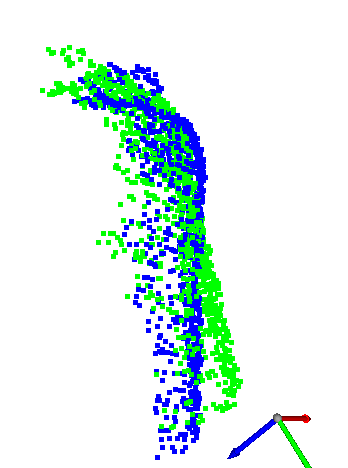

第2次迭代后的结果与$pts2(blue)$

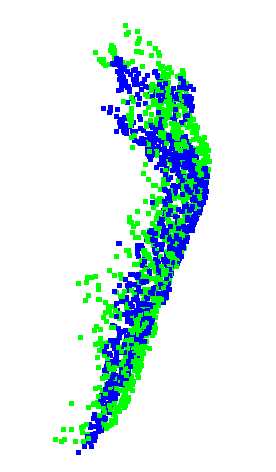

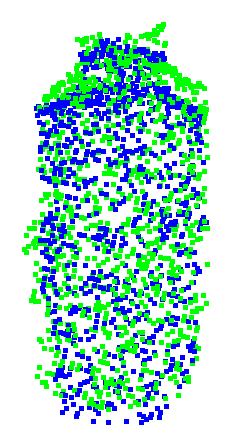

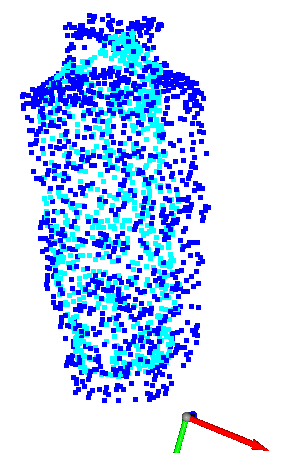

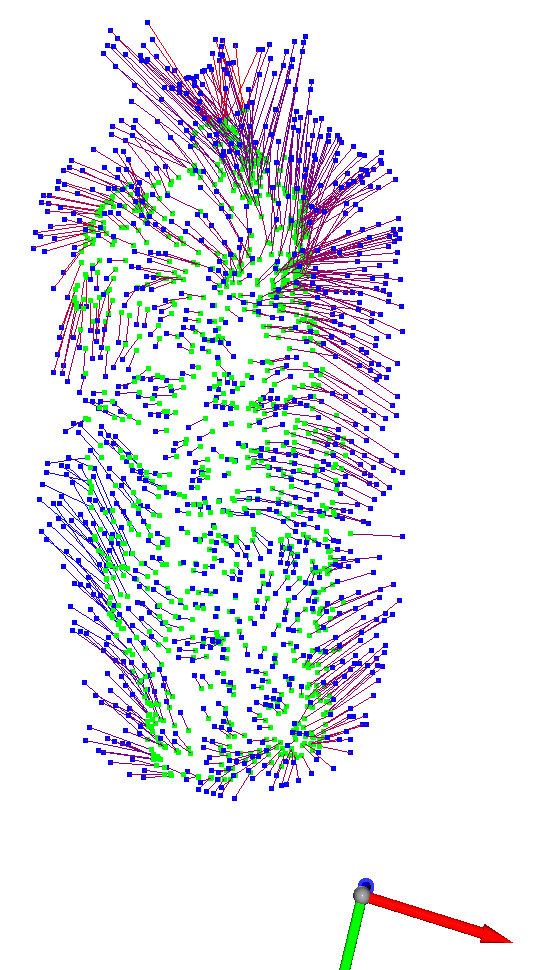

蓝色为最终变换到cur帧的base帧点云，绿色为$A*pts2$观察可以发现，缩小的问题变得更加明显了。

## 6.用一个hard-corr去约束soft-corr是否不合理？

### 6.1 hard-2-soft

nn最近邻发现一个点后，不急着将该点权重设置为1.将该点移除后，从剩下的点继续找一个点出来，一直到找够n个点，然后将这n个点按距离加权。

# 708训练之后，这是在15轮基础上继续训练了25轮的结果

第10帧，相邻两帧

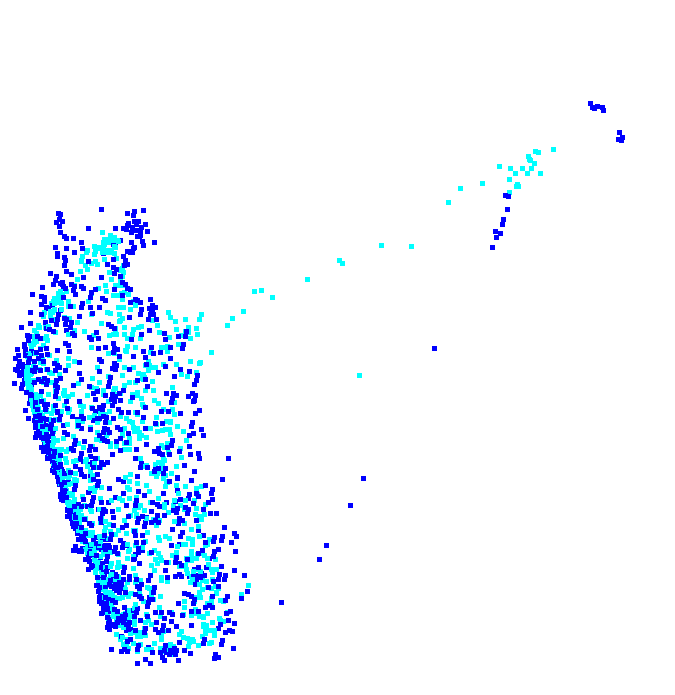

可以发现拖尾估计的并不准确

base与cur，可以发现倾斜的问题依然存在

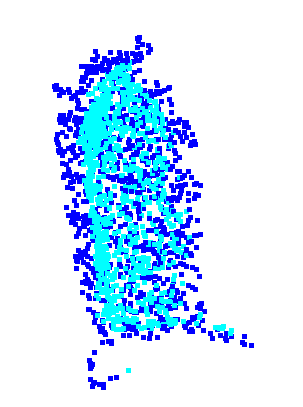

测试一下将base添加一个旋转是否还会有同样的问题？

# 待做实验

## 1.测试目前的gt_corr_matrix是否在整个序列上都准确，都能保证$\{I|0\}$

## 2.如果训练一个segnet

两种策略，一种是根据特征匹配来判断哪些点是不匹配的点。另一种是根据单个点云，分类哪些点是背景点（分类前背景）

### 2.1 两组点云判断不匹配

### 2.2 前背景分类

### 2.3 优化wd_loss来抑制错误加权

## 3.对input点云进行添加一个旋转扰动，看看其TSNE相比于之前是否发生变化？

## 4.【完成】测试理想情况下,(每10帧固定一次的误差是0,最终结果如何)

In [ ]:
2023-07-11 12:14:44,708 : Total eval: sdiff_sym: 3.693812899996374e-08
2023-07-11 12:14:44,708 : Total eval: tdiff_sym: 0.004317192360758781
2023-07-11 12:14:44,709 : Total eval: rdiff_sym: 2.4950664043426514
2023-07-11 12:14:44,709 : Total eval: 5deg5cm_sym: 0.9240283370018005
2023-07-11 12:14:44,709 : Total eval: 10deg10cm_sym: 0.9810292720794678

\\\\\\\ bottle bowl camera can laptop mug Overall

5°5cm 86.5 99.6 85.8 99.2 99.9 53.6 87.4

IoU25 100.0 99.9 99.9 100.0 99.9 99.9 99.9

Rerr 1.6 1.7 3.0 1.5 1.5 5.2 2.4

Terr 2.3 2.1 2.1 2.1 2.2 2.2 2.1

测试一下：理想情况下，拿bottle训练，在bowl上测试

In [ ]:
2023-07-11 13:42:15,494 : Total eval: sdiff_sym: 4.1582790544225645e-08
2023-07-11 13:42:15,494 : Total eval: tdiff_sym: 0.003554718568921089
2023-07-11 13:42:15,494 : Total eval: rdiff_sym: 2.3373336791992188
2023-07-11 13:42:15,494 : Total eval: 5deg5cm_sym: 0.9257559180259705
2023-07-11 13:42:15,494 : Total eval: 10deg10cm_sym: 0.9838184714317322

## 5.试试用(1,2),(3,4),(5,6),...,(n-1,n)帧之间的gt_corr_matrix连乘,然后计算(1,n)之间的gt_corr_matrix，比较两者的不同。看看A连续相乘后会发生什么

## 5.1 不对应点的整行为0是否会成为问题

## 6.关键帧使用ICP与之前的base进行位姿估计，看看效果如何

https://github.com/strawlab/python-pcl/issues/376

python-pcl使用其中的icp模块需要使用numpy==1.17.5，目前的是1.19因此需要conda uninstall numpy卸载重新安装

In [ ]:

The following packages will be REMOVED:

    boost:    1.64.0-py36_4       conda-forge
    mkl_fft:   1.3.0-py36h54f3939_0
    mkl_random:  1.1.1-py36h0573a6f_0
    numpy:    1.19.2-py36h54aff64_0
    pcl:     1.8.1-0          sirokujira
    python-pcl:  0.3.0-py36_0       sirokujira
    torchvision: 0.11.2-py36_cu113     pytorch


In [ ]:
# 目前的方法在24帧时误差会达到临界，开始失效
util frame: 23
resume_model 1+2 :
sdiff: 6.154827758564352e-08
tdiff: 0.005439648870378733
rdiff: 3.615595579147339
5deg5cm: 1.0
10deg10cm: 1.0
o_rate: 1.0
current frame rotation diff: 4.856153964996338
current frame rotation diff[no sym]: 6.971785545349121

util frame: 24
resume_model 1+2 :
sdiff: 6.332993507385254e-08
tdiff: 0.0056286342442035675
rdiff: 3.700585126876831
5deg5cm: 0.9583333730697632
10deg10cm: 1.0
o_rate: 0.98046875
current frame rotation diff: 5.655339241027832
current frame rotation diff[no sym]: 11.021801948547363

测试使用ICP重置关键帧，即对第23or24帧使用ICP估计位姿。
看与当前的位姿差异相比有多大。





pcl库中应该有ICP实现，看看效果如何。

## 7.关键帧更新策略问题

### 7.1 每隔n帧更新一次

### 7.2 旋转每当超过m度更新一次

## 8.3DIoU计算问题，此前所有的方法在评估时都有错误

[SAR-Net-issues-16](https://github.com/hetolin/SAR-Net/issues/16)

## 9.测试使用knn来生成软对应的A

### 9.1 每一行的最大池化并不有效

### 9.2 每一行的top-k,重新归一化，来生成软对应权重

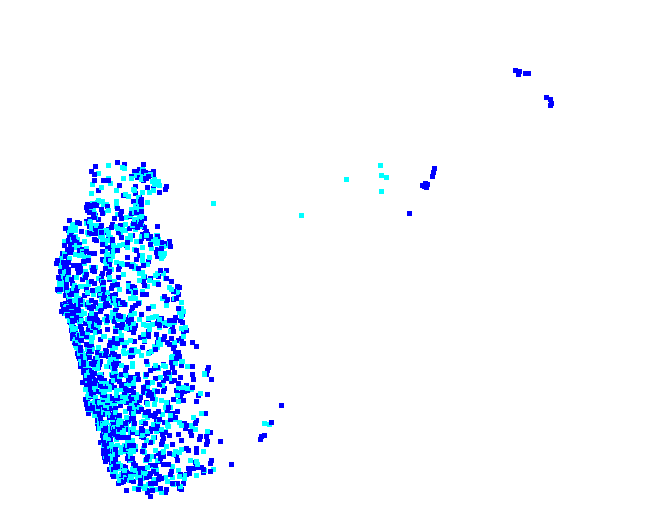

上图中的A为将每一行的top-k个点重新归一化权重得到的，可以发现缩小的问题几乎小时，除了拖尾有一部分问题。

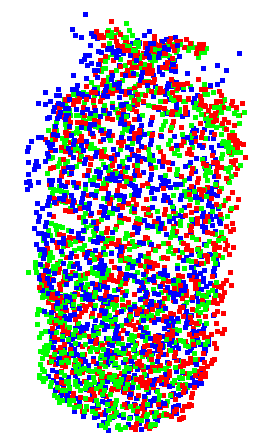

上图为 **不使用** 新perm_matrix加权Umeyama的点云(红色)

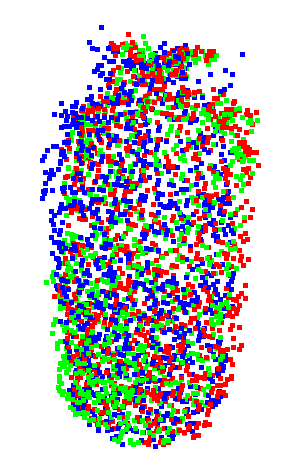

上图为使用 新perm_matrix加权Umeyama的点云(红色)



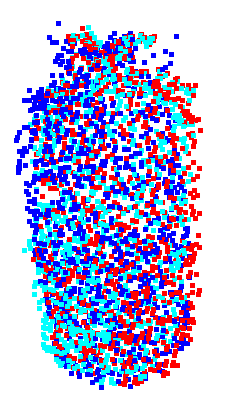

浅蓝色:old_perm, 红色: new_perm

定量比较

In [ ]:
2023-07-19 08:20:24,293 : final color (sym):
2023-07-19 08:20:24,294 : sdiff: 5.960464477539063e-08
2023-07-19 08:20:24,294 : tdiff: 0.007069985382258892
2023-07-19 08:20:24,294 : rdiff: 7.600289344787598

# 使用top-k的两种方法
2023-07-19 08:19:49,896 : diff_with_perm (sym):
2023-07-19 08:19:49,897 : sdiff: 5.960464477539063e-08
2023-07-19 08:19:49,897 : tdiff: 0.10867054760456085
2023-07-19 08:19:49,897 : rdiff: 8.124147415161133

# 可以发现, 使用topk, 同时,原本点加权，则能够降低旋转误差
2023-07-19 08:19:49,897 : diff_without_perm (sym):
2023-07-19 08:19:49,897 : sdiff: 5.960464477539063e-08
2023-07-19 08:19:49,897 : tdiff: 0.09398927539587021
2023-07-19 08:19:49,898 : rdiff: 6.6474432945251465

# 但是t增大了很多，在图像上却看不出来，是否有错误？

In [ ]:
# 使用ssc
# 持续使用到135帧
util frame: 134
resume_model 1+2 :
sdiff: 5.204286068760666e-08
tdiff: 0.0073800343088805676
rdiff: 4.470910549163818
5deg5cm: 0.641791045665741
10deg10cm: 1.0


util frame: 134
resume_model 1+2 :
sdiff: 5.204286068760666e-08
tdiff: 0.006966891698539257
rdiff: 4.795554161071777
5deg5cm: 0.4477611780166626
10deg10cm: 1.0

# 每次测试的结果有浮动, 而且很大，可能与ssc的分割结果有关？
# gt_corr_matrix约束得到的结果
util frame: 134
resume_model 1+2 :
sdiff: 5.204286068760666e-08
tdiff: 0.005372968968003988
rdiff: 3.0831034183502197
5deg5cm: 0.7537313103675842  # 75%
10deg10cm: 1.0
o_rate: 1.0
current frame rotation diff: 6.914095878601074
current frame rotation diff[no sym]: 40.883140563964844


# 使用gt的测试结果
# 1. 1,2阶段都gt_Corr_Net
util frame: 134
resume_model 1+2 :
sdiff: 5.204286068760666e-08
tdiff: 0.006757086608558893
rdiff: 5.974924564361572
5deg5cm: 0.31343284249305725  # 30%
10deg10cm: 0.9179103970527649
current frame rotation diff: 10.124770164489746
current frame rotation diff[no sym]: 53.53959655761719

# gt_Corr_Net将Corr_Net网络估计对应矩阵A的部分替换为：nocs_base与nocs2使用nn计算得到的对应矩阵，因为是nocs下计算的，因此也能直接应用到观测点云上
# 2. 1阶段Corr_Net, 2阶段gt_Corr_Net
sdiff: 5.204286068760666e-08
tdiff: 0.04586898908019066
rdiff: 65.01546478271484
5deg5cm: 0.0746268630027771  # 7% 跟丢
10deg10cm: 0.09701492637395859

# 2. 1阶段gt_Corr_Net, 2阶段Corr_Net
util frame: 134
resume_model 1+2 :
sdiff: 5.204286068760666e-08
tdiff: 0.06272498518228531
rdiff: 77.10489654541016
5deg5cm: 0.05223880335688591  # 5% 跟丢
10deg10cm: 0.0746268630027771
o_rate: 0.0
current frame rotation diff: 54.604278564453125
current frame rotation diff[no sym]: 74.35580444335938

可以得出结论：**单个最近邻点生成gt_corr_matrix的方法效果差**

## 10.测试nn方法生成的gt_corr_matrix对于较远的两nocs帧是否有效？

## 11.对A的每一行的top-k进行归一化

## 12.双向A能否约束不匹配的点?

在论文Correspondence is Derated中, 生成对应矩阵的ground truth的代码是这样的

In [ ]:
def nn_hard_corr(self, src, ref, inl_threshold_param=0.02):
    # src = sample['points_src'][:, :3]
    # ref = sample['points_ref'][:, :3]

    inl_threshold = inl_threshold_param  # threshold to decide whether a point is an inlier
    out_threshold = inl_threshold * 2  # threshold to decide whether a point is an outlier

    # mutual Nearest-Neighbor search
    nn_search = NearestNeighbors(n_neighbors=1, metric='minkowski', p=2)
    nn_search.fit(ref)
    nndist1, nnidx1 = nn_search.kneighbors(X=src, n_neighbors=1, return_distance=True)
    # X 的shape为 (n_queries, n_features)
    # 返回值:
    # dist和idx均用于ref, 即ref中第i个点,在src的最近邻点的下标为nnidx1[i]
    # nndist1 :  距离          neigh_distndarray of shape (n_queries, n_neighbors)
    # nnidx1  :  点在X中的下标  neigh_indndarray of shape (n_queries, n_neighbors)

    # 每个点只挑选最近的一个近邻点
    nndist1 = nndist1[:, 0]
    nnidx1 = nnidx1[:, 0]

    nn_search = NearestNeighbors(n_neighbors=1, metric='minkowski', p=2)
    nn_search.fit(src)
    nndist2, nnidx2 = nn_search.kneighbors(X=ref, n_neighbors=1, return_distance=True)
    nndist2 = nndist2[:, 0]
    nnidx2 = nnidx2[:, 0]

    pc1_mnn_mask = np.take(nnidx2, nnidx1) == np.arange(nnidx1.shape[0])  # mutual NN mask
    # 创建一个(n, m)的零矩阵,  src(m,3)对应2, ref(n,3)对应1
    corr_mat = np.zeros((nnidx1.shape[0], nnidx2.shape[0]), dtype=np.int64)
    corr_mat[np.arange(nnidx1.shape[0]), nnidx1] = 1  # 每一行, 将对应的下标设置为1 set ones
    corr_mat[~pc1_mnn_mask, :] = 0  # if not mutual, set zero
    inlier_mask = nndist1 < inl_threshold
    corr_mat[~inlier_mask, :] = 0  # if not inlier, set zero

    assert (np.sum(corr_mat, axis=1).max() <= 1)  # assert one-to-one relationship
    assert (np.sum(corr_mat, axis=0).max() <= 1)

    corr_mat_gt = corr_mat.astype(np.float32)

    return corr_mat_gt

np.take(nnidx2, nnidx1)，nnidx1作为下标, 从nnidx2中提取元素，nnidx2是src在ref中的最近点 (1024,)，nnidx1是ref在src中的最近点 (1024,)

那么, 假设nnidx2[i]==j, 说明src中的第i个点在ref中的最近点是j，也就是去nnidx1中取第j个值nnidx[j], 即ref中的第j个点在src中的最近点。

假设nnidx[j]==k, ref中的第j个点在src中的最近点为k，此时== np.arange(nnidx1.shape[0])则是在判断k和i是否相等，其实就是判断: src中i点的最近点j, j的最近点是否为i
只有两个都相等时, pc1_mnn_mask中才会为True；否则最终就会被置为0, 其实和双向很类似

**能否将这一个hard-corr下的思路转移到soft-corr下？**

理一下:

**hard-corr**

> $p_1$点云中点$p_a$在$p_2$中的最近点为$p_b$
  
要求反过来也成立,即:

> $p_2$点云中点$p_b$在$p_1$中的最近点为$p_a$

**soft-corr**

$p_1$中的点在$p_2$中与k个点相关, 可通过这些点加权得到

> $p_1$点云中点$p_a$在$p_2$中的最近点为$p_b$



## 13.无法加权得到的点怎么办？

## 14.目前的corr_loss是如何约束的

目前使用的损失函数如下

In [ ]:
loss_value_batch = -torch.sum(corr_mat_gt_batch * torch.log(corr_matrix_batch + 1e-8), dim=[-1, -2]) / (torch.sum(corr_mat_gt_batch, dim=[-1, -2]) + 1e-8)

该损失函数

$Loss=\frac{1}{\sum \log{A_{gt}}}(\sum A_{pred}*\log{A_{gt}})$

常见于多分类任务，需要注意的是，分子部分并非矩阵乘法，而是对应点相乘。因此，理想情况下，分子部分的$A_{pred}*\log{A_{gt}}=\log{A_{gt}}$，因为在$A_{pred}$中与gt对应的位置都是1，不对应的位置都是0。因此，其实和之前的corr_loss有点像，都没有估计错误的对应进行惩罚。这也是导致最终权重平均化的结果。

因为平均化更不容易出错，像把鸡蛋放入所有篮子一样，对于有信心的多增加一点权重。对了也对的不多，错了也错的不多。

**上面的理解有错误 **

$A_{gt}$将不匹配的位置设置为非常小的常数，匹配的位置设置为1.
因此，当计算log的时候，不匹配位置就会取一个非常大的负值。匹配位置则是$ln1$=一个小的负值。那么是否可以设置多个1，也就是给多个匹配点？

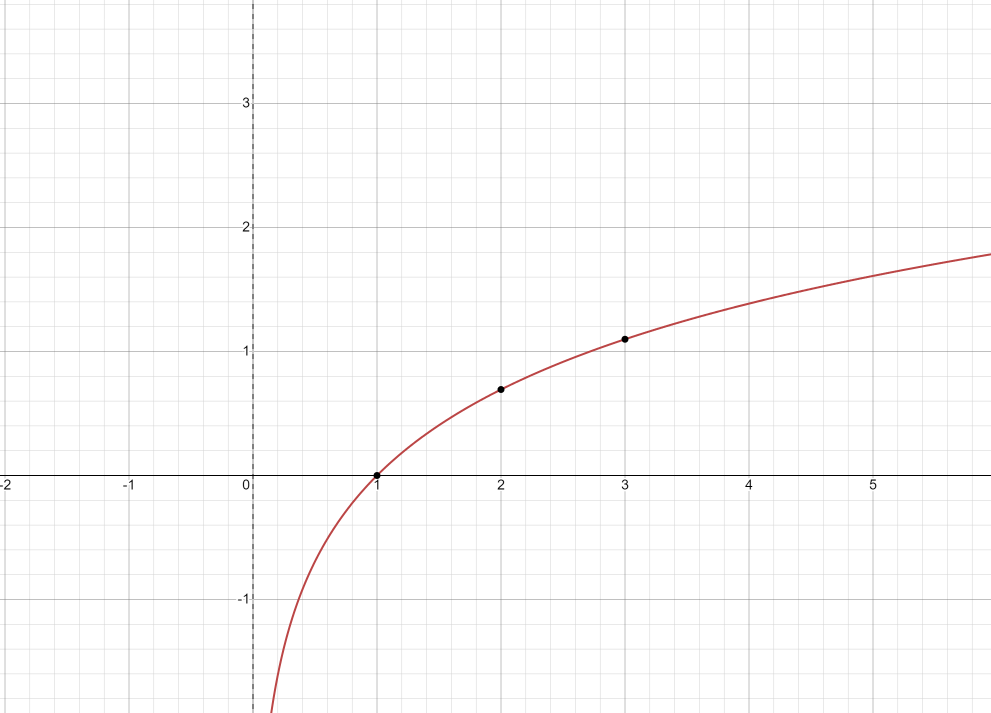

## 15. LightGlue的思路

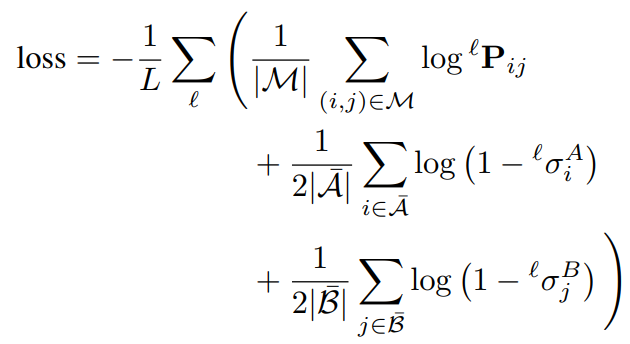

LightGlue也是直接约束的对应矩阵A，其处理的是图像，使用双视角的depth图像和一个相对位姿，将A中的点变换到B中，排除深度差异大的点，对于重投影误差和深度误差较大的点，将其标记为不匹配点。使用其他的Loss来进行惩罚


1.生成gt_corr_matrix时候，先将nocs变换到相机坐标系下，将投影差异大的点排除掉。（可以考虑重新生成NOCS map）

2.看loss中第一项，$M$为对应矩阵的ground truth，在对网络预测的对应矩阵$P$计算loss时，只计算$M$中有的项

# to do list

## 1. $A_{gt}$使用当前的网络生成初值，然后生成soft-corr的$A_{gt}$

思考了一个问题：
所谓的按距离分配权重，应用在points的3D空间上其实是不对的。
按距离分配权重，分配的权重$w_i$应当分配到特征上，让特征空间中能够加权得到正确的对应点

例如pts1中的点$p_1$，其在pts2中有多个对应点$p_j$，那么对$p_1$提取的特征$f_1$，在特征空间下，应该可以由特征$f_j$加权得到，应该有

$f_1=\sum w_jf_j$

而这一映射在pts所在的三维空间下是很难成立的，因为周围的点$p_j$必须满足一定的分布才有能力加权得到$p_i$，为此network其实是为了学校到目标特征空间的映射，该映射满足通过权重w的加权这一条件。

为此，特征空间下的映射得到了，也就产生了约束条件，但是该约束条件最终还是映射特征变为映射点,$F_1 = CF_2$，同样的，$P_1=CP_2$

Correspondence Matrices are Underrated效果差的原因，可能是因为其使用的是密集点云，在生成$A_{gt}$时应该使用$NOCS_{dense}$来生成。LightGlue也是使用密集点云重投影，得到投影误差小的点来作为GT。

如果使用采样1024个点之后的点云$NOCS_1$和$NOCS_2$，就会出现原本密集点云中对应点在另一个点云中没有采样到的情况。

**如何克服？**



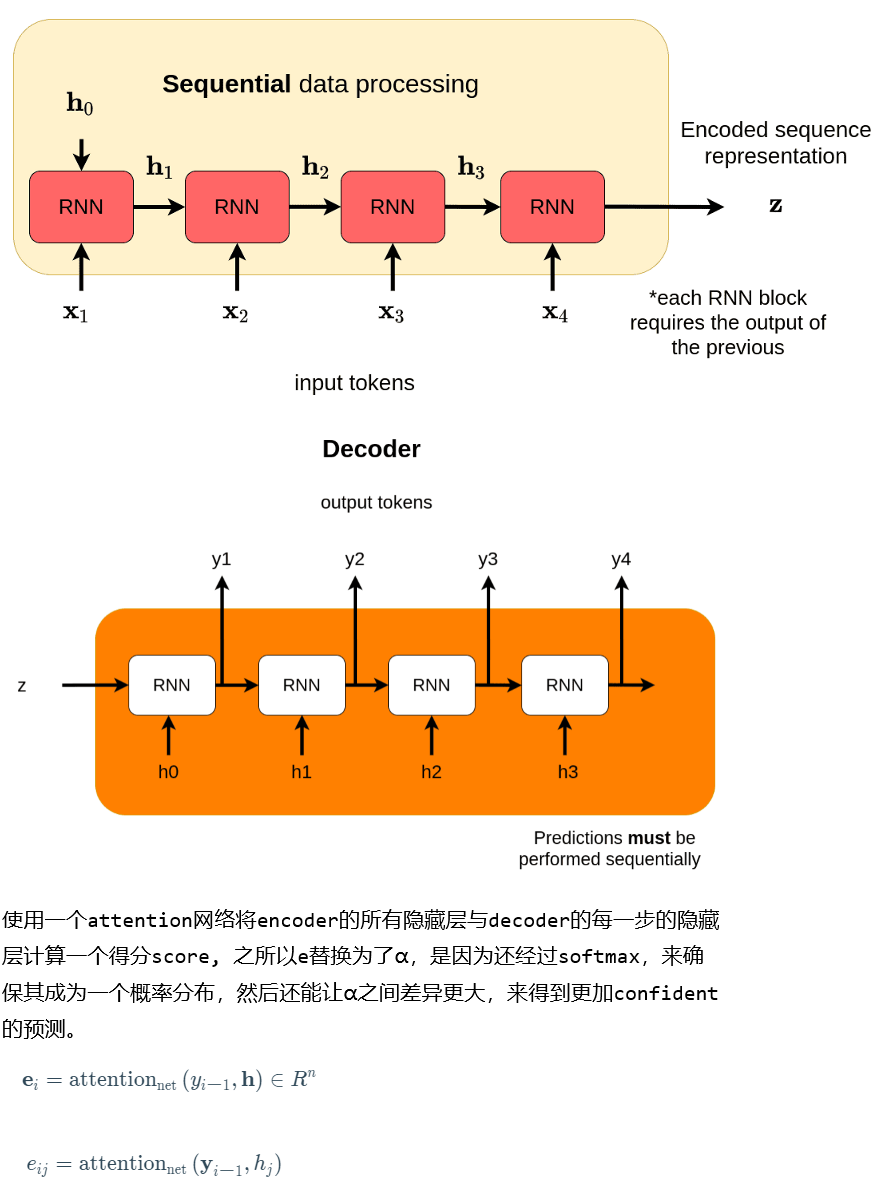

能否通过一个attention来计算点对之间的得分？

为什么Encoder-Decoder结构生成的中间结果可以作为估计？

## 2.序列上的A进行BA

## 3.学习LightGlue为A添加一个辅助的向量V,标记哪些点对被排除在外

## 4.添加迭代以估计更准确的A

使用前一次迭代的权重高的点来匹配。即下一次生成权重时候，只能对上一次权重高的对应点分配权重。

In [ ]:
# A[focus_index, idx]为权重超过均值的点
# 可以发现和为95%
torch.sum(A[focus_index, idx])
Out[5]: tensor(0.9586, device='cuda:0')

torch.max(A[focus_index, idx])
Out[6]: tensor(0.0390, device='cuda:0')

在RPMNet的match_feature中：

In [ ]:
dist_matrix = square_distance(feat_src, feat_ref)  # 计算两两点距离的平方

In [ ]:
def square_distance(src, dst):
    """Calculate Euclid distance between each two points.
        src^T * dst = xn * xm + yn * ym + zn * zm；
        sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
        sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
        dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
             = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Args:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]
    Returns:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    # 其实就是模拟了 x^2+2xy+y^2这个过程，本质就是一个计算两个feature空间的欧式距离的平方
    # 所以，如果将一些点给删除掉，其实在这里并没有意义，因为这里只考虑feat1中的某一个到feat2中的所有feat在特征空间的欧式距离
    # 如果要添加prune操作的话，需要的是对所有的feat进行归一化操作的地方

    # 考虑在feat归一化的时候添加？
    # 不对，上面的结论有问题，match_feature一方面是计算特征相似度，另一方面，两组feat之间生成权重靠的其实是在归一化时候所有具有权重的点
    # 也就是说，将部分点计算出的特征相似度排除在外之后，重新计算出的特征相似度。其实和使用torch.mean过滤之后，
    # 然后将所有点通过重新归一化，结果是相同的？？？？？

    # 不对，其实可以使用每一次layer计算得到的位姿，将该位姿施加到points_base上，然后重新提取feat，重新计算特征相似度。
    # 通过两方面：1.从新的点云重新生成的feat。2.新的feat在于points2的feat2进行匹配的时候，上一层score小于一定值的点被过滤掉。
    # 由此达成迭代的位姿估计，实现逐步逼近的效果。

    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))  # (B, N, C)*(B, C, M)
    dist += torch.sum(src ** 2, dim=-1)[:, :, None]
    dist += torch.sum(dst ** 2, dim=-1)[:, None, :]
    return dist

即在$F_1$和$F_2$在执行match_feat得到最终的cmat的时候，对每一行能够使用一个额外的P矩阵，标记能和F2中的哪一些进行匹配。不进行匹配的不生成权重，生成权重的部分只有上一层layer中权重超过一定阈值的部分，通过层层堆叠，权重最终会集中到数个点上。

但是，还有一个要考虑的问题是，如何确定停止条件？

一个方法是将阈值设置为超参数，即在当前的layer，没有点被排除在外

另一个方法，在当前的layer，排除后剩余的点数量是0

类似于LightGlue中的点修剪策略(point pruning)，其设计了一个分类器，将点划分为两种：confident和unmatchable两种，将confident的点继续输入下一层。

仅仅依赖当前的$F1$和$F2$计算一个特征相似度, 难以划分是否匹配。

In [ ]:
class LightGlue(nn.Module):

  ...

  def _forward(self, data: dict) -> dict:
      for key in self.required_data_keys:
          assert key in data, f'Missing key {key} in data'
      data0, data1 = data['image0'], data['image1']
      kpts0_, kpts1_ = data0['keypoints'], data1['keypoints']
      b, m, _ = kpts0_.shape
      b, n, _ = kpts1_.shape
      size0, size1 = data0.get('image_size'), data1.get('image_size')
      size0 = size0 if size0 is not None else data0['image'].shape[-2:][::-1]
      size1 = size1 if size1 is not None else data1['image'].shape[-2:][::-1]
      kpts0 = normalize_keypoints(kpts0_, size=size0)
      kpts1 = normalize_keypoints(kpts1_, size=size1)

      assert torch.all(kpts0 >= -1) and torch.all(kpts0 <= 1)
      assert torch.all(kpts1 >= -1) and torch.all(kpts1 <= 1)

      desc0 = data0['descriptors'].detach()
      desc1 = data1['descriptors'].detach()

      assert desc0.shape[-1] == self.conf.input_dim
      assert desc1.shape[-1] == self.conf.input_dim

      if torch.is_autocast_enabled():
          desc0 = desc0.half()
          desc1 = desc1.half()

      desc0 = self.input_proj(desc0)
      desc1 = self.input_proj(desc1)

      # cache positional embeddings
      encoding0 = self.posenc(kpts0)
      encoding1 = self.posenc(kpts1)

      # GNN + final_proj + assignment
      do_early_stop = self.conf.depth_confidence > 0
      do_point_pruning = self.conf.width_confidence > 0 # width_confidence参数用来控制point pruning
      if do_point_pruning:
          # 创建(m,)和(n,)大小的向量作为prune标记，对应(m,3)的pts1和(n,3)的pts2，初始时将所有下标的prune置为1
          ind0 = torch.arange(0, m, device=kpts0.device)[None]
          ind1 = torch.arange(0, n, device=kpts0.device)[None]
          # We store the index of the layer at which pruning is detected.
          prune0 = torch.ones_like(ind0)
          prune1 = torch.ones_like(ind1)

      token0, token1 = None, None

      for i in range(self.conf.n_layers):
          desc0, desc1 = self.self_attn[i](
              desc0, desc1, encoding0, encoding1)
          desc0, desc1 = self.cross_attn[i](desc0, desc1)
          if i == self.conf.n_layers - 1:
              continue  # no early stopping or adaptive width at last layer

          if do_early_stop:
              token0, token1 = self.token_confidence[i](desc0, desc1)
              if self.check_if_stop(token0, token1, i, m+n):
                  break
          if do_point_pruning:
              # 描述子desc0和desc1分别得到1个分数
              scores0, scores1 = self.log_assignment[i].scores(desc0, desc1)
              mask0 = self.get_pruning_mask(token0, scores0, i)
              mask1 = self.get_pruning_mask(token1, scores1, i)
              ind0, ind1 = ind0[mask0][None], ind1[mask1][None]
              desc0, desc1 = desc0[mask0][None], desc1[mask1][None]
              if desc0.shape[-2] == 0 or desc1.shape[-2] == 0:
                  break
              encoding0 = encoding0[:, :, mask0][:, None]
              encoding1 = encoding1[:, :, mask1][:, None]
              prune0[:, ind0] += 1
              prune1[:, ind1] += 1

      scores, _ = self.log_assignment[i](desc0, desc1)
      m0, m1, mscores0, mscores1 = filter_matches(
          scores, self.conf.filter_threshold)

      matches, mscores = [], []
      for k in range(b):
          valid = m0[k] > -1
          m_indices_0 = torch.where(valid)[0]
          m_indices_1 = m0[k][valid]
          if do_point_pruning:
              m_indices_0 = ind0[k, m_indices_0]
              m_indices_1 = ind1[k, m_indices_1]
          matches.append(torch.stack([m_indices_0, m_indices_1], -1))
          mscores.append(mscores0[k][valid])

      # TODO: Remove when hloc switches to the compact format.
      if do_point_pruning:
          m0_ = torch.full((b, m), -1, device=m0.device, dtype=m0.dtype)
          m1_ = torch.full((b, n), -1, device=m1.device, dtype=m1.dtype)
          m0_[:, ind0] = torch.where(
              m0 == -1, -1, ind1.gather(1, m0.clamp(min=0)))
          m1_[:, ind1] = torch.where(
              m1 == -1, -1, ind0.gather(1, m1.clamp(min=0)))
          mscores0_ = torch.zeros((b, m), device=mscores0.device)
          mscores1_ = torch.zeros((b, n), device=mscores1.device)
          mscores0_[:, ind0] = mscores0
          mscores1_[:, ind1] = mscores1
          m0, m1, mscores0, mscores1 = m0_, m1_, mscores0_, mscores1_

      pred = {
          'matches0': m0,
          'matches1': m1,
          'matching_scores0': mscores0,
          'matching_scores1': mscores1,
          'stop': i+1,
          'matches': matches,
          'scores': mscores,
      }
      if do_point_pruning:
          pred.update(dict(prune0=prune0, prune1=prune1))
      return pred

### LightGlue filter_matches code


filter_matches函数接受一个scores和一个阈值th作为输入，其中scores来自两个特征描述子。因此本函数可以视为对两个特征匹配的结果进行过滤。

其中的代码与CMU中的非常相似，因此可以分析一下相同与不同。

In [ ]:
def filter_matches(scores: torch.Tensor, th: float):
    """ obtain matches from a log assignment matrix [Bx M+1 x N+1]"""
    # max0和max1分别记录scores的行列最大值以及相对应的下标, 包含value和indice两部分
    max0, max1 = scores[:, :-1, :-1].max(2), scores[:, :-1, :-1].max(1)
    m0, m1 = max0.indices, max1.indices

    # 生成一个mask, 来选择双向对应的点
    # mutual0和mutual1与CMU中的思路相同, 这里都是在判断点之间的对应必须是双向的
    # 此处的对应必须是一一对应，也是密集点云的优势或者说可以使用的特性。像是FPS采样后的点云就没法使用这一思路。
    mutual0 = torch.arange(m0.shape[1]).to(m0)[None] == m1.gather(1, m0)
    mutual1 = torch.arange(m1.shape[1]).to(m1)[None] == m0.gather(1, m1)
    max0_exp = max0.values.exp()
    zero = max0_exp.new_tensor(0)
    # 创建mscores0和mscores1, 将一一对应的部分设置为e^max, 不能一一对应的则设置为0
    mscores0 = torch.where(mutual0, max0_exp, zero)
    mscores1 = torch.where(mutual1, mscores0.gather(1, m1), zero)
    # 同时, 使用阈值th对mscores0进行过滤, 只保留得分大于th的部分
    if th is not None:
        valid0 = mutual0 & (mscores0 > th)
    else:
        valid0 = mutual0
    valid1 = mutual1 & valid0.gather(1, m1)
    #
    m0 = torch.where(valid0, m0, m0.new_tensor(-1))
    m1 = torch.where(valid1, m1, m1.new_tensor(-1))
    return m0, m1, mscores0, mscores1

### 迭代过程

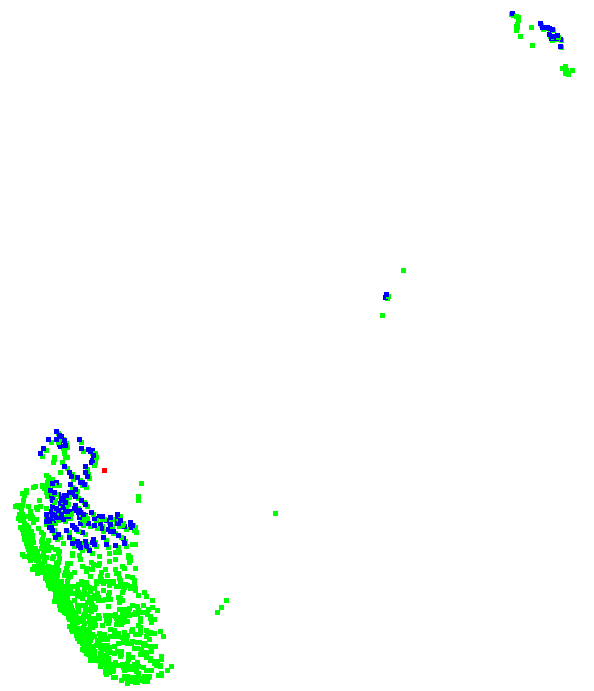

红色为最终加权生成点, 蓝色为参与加权点,这些点占据了权重的95%，绿色点为原点云。



### 问题汇总

Q:是否可以根据距离远近来删除并过滤点？像是拖尾这种能够很容易地被去除掉。
A1:

(1)有一个问题，红色点并非gt点，无法知道红色点的位置距离真正的最终点差多少。
但是是否可以学习wd_loss一样，权重越大的点越近，重新分配权重？

目前的对应矩阵来自于特征相似度。红色点和蓝色点的关系也是特征相似度的结果。如果仅仅是将权重值小于一定值的点排除掉，很难继续聚合权重。

$M = match(F_1, F_2)$

$A = normalize(M)$

(2)还有一个问题，目前可视化中, 蓝色点为权重大于weight_mean的点, 但是在实际中, 因为归一化后的点始终为mean=1/1024
解决方案: 使用一个标记矩阵V, 每次迭代中, 将权重小于mean的点标记为0, 同时另一个向量V_num, 记录每一个行还剩下多少不为0的点, 计算mean的时候将V中为0的点排除掉，这样能够逐渐拔高门槛。

(3)迭代的终止条件, 当某一个点的加权点数量小于4个, 标记为该点加权end。当足够数量的点满足该条件后，终止迭代。
另外，LightGlue中提到的置信度高和置信度低的点应当排除在外，因为这些点的对之后匹配的作用有限，该假设或许也可以测试一下。

(4)是否可以通过一个softmax来增大方差? 或者ICG中的光滑函数f, 将当前的分布d乘以函数f来获得接近高斯分布的新分布。

但是当前的分布未必就是正确的分布, 单纯将分布的方差增大是否会有效果？


(5)这样逐渐缩小范围的方式, 和一开始就用topk有什么不同？是否是等价的？[测试]


(6)关键帧添加策略, 旋转or位移超过一定程度添加关键帧

#### 7.26-test均值排除点
单纯使用mean来删除点没有用, 剩下的点在计算特征相似度时, 最终得到的权重相比于原来几乎没有变化。需要从$F_1,F_2->featrue_distance$入手解决。
参考LightGlue的filter_matches函数

In [ ]:
# corr_matrix 原本的A
# c 将部分点设置为0
corr_matrix[0,0,:]
Out[18]:
tensor([4.5080e-04, 3.2857e-03, 3.2272e-03,  ..., 3.6158e-07, 4.6562e-07,
        7.8221e-07], device='cuda:0')
c[0,0,:]
Out[19]:
tensor([2.6111e-21, 3.6196e-03, 3.5297e-03,  ..., 1.1769e-21, 1.1677e-21,
        1.1419e-21], device='cuda:0')
corr_matrix[0,0,:].max()
Out[20]: tensor(0.0766, device='cuda:0')
c[0,0,:].max()
Out[21]: tensor(0.0799, device='cuda:0')

# 可以发现权重确实聚拢了, 但是效果并不大。

#### 7.27 测试 按距离重新分配权重

按照加权后的点与参与加权点的距离, 重新评估点对当前点的影响力。

一方面看看权重相比于原来，如何变化。

另一方面，看看这样是否能够聚拢权重，快速过滤点。

**在Umeyama计算位姿时, perm_matrix也应该按照权重重新加权？**

但是perm_matrix应该已经受到V的影响了

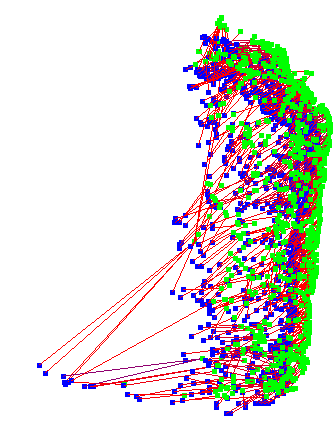

虽然能够聚拢权重, 但是最终生成的A*pts2还是(1024, 3)的, 这意味着, 依然是强制为每一个点找一个对应点。并且，无论是RPMNet的beta,alpha，还是在Umeyama中的权重，都没有能够过滤任何点对。

解决方案: 将assist_matrix作为权重输入Umeyama中, 如果assist_matrix的某一行全部被置为0, 则该行对应的点对不会参与此次的位姿估计。

**是否可以在每一layer独立设置一个矩阵V_w, 最终迭代结束后，将所有的V_w对应位置相加, 最终值越高则该点的score越高**

#### 7.28 test 迭代

从第180帧更新base开始, 结果出现巨大偏差。

In [ ]:
# 测试
"""
2023.7.28
https://github.com/winka9587/SGPA/commit/d0f23acf45a89a93d1630a41373a062869903599

A:\WorkPlace\PyCharm\SGPA_RPM\visualize_eval_NewModel_iter.py
--dataset
Real
--gpu
7
--resume_model
results/Real/711_1_gt_corr_nrm_resume/bottle/model_15.pth
--m1_feat
nrm
--resume_model_2
results/Real/711_1_gt_corr_nrm_resume/bottle/model_15.pth
--m2_feat
nrm
--folder_name
eval
--cat_id
1
--use_crop
"""

# 迭代过程
iter: 0
nrm result [cmp]
sdiff: 1.4901161193847656e-08
tdiff: 0.04420311376452446
rdiff: 36.16607666015625
iter 0 result
sdiff: 1.4901161193847656e-08
tdiff: 0.022559933364391327
rdiff: 12.71229362487793
remove points: 0.0
tensor([0.0140, 0.0127, 0.0119, 0.0146, 0.0148, 0.0343, 0.0058, 0.0305, 0.0297,
        0.0152, 0.0126, 0.0287, 0.0055, 0.0078, 0.0200, 0.0093, 0.0060, 0.0057,
        0.0080, 0.0213, 0.0272, 0.0072, 0.0064, 0.0067, 0.0058, 0.0131, 0.0144,
        0.0182, 0.0194, 0.0137, 0.0162, 0.0157, 0.0100, 0.0064, 0.0098, 0.0117,
        0.0146, 0.0146, 0.0061, 0.0088, 0.0099, 0.0138, 0.0137, 0.0151, 0.0072,
        0.0073, 0.0058, 0.0067, 0.0112, 0.0103, 0.0068, 0.0048, 0.0068, 0.0049,
        0.0044, 0.0082, 0.0091, 0.0084, 0.0082, 0.0060, 0.0056, 0.0050, 0.0044,
        0.0062, 0.0079, 0.0075, 0.0084, 0.0086, 0.0075, 0.0042, 0.0050, 0.0051,
        0.0051, 0.0081, 0.0109, 0.0077, 0.0040, 0.0040, 0.0042, 0.0092, 0.0083,
        0.0066, 0.0047, 0.0035, 0.0038, 0.0033, 0.0034, 0.0039, 0.0046, 0.0070,
        0.0040, 0.0032, 0.0028, 0.0025, 0.0047, 0.0061, 0.0026, 0.0027, 0.0038,
        0.0044, 0.0060, 0.0071, 0.0035, 0.0050, 0.0066, 0.0057, 0.0061, 0.0037,
        0.0019, 0.0042, 0.0038, 0.0026, 0.0022, 0.0044], device='cuda:0')
max :0.034291431307792664
mean:0.008771808817982674
min :0.0019091700669378042
iter: 1
nrm result [cmp]
sdiff: 1.4901161193847656e-08
tdiff: 0.04420311376452446
rdiff: 36.16607666015625
iter 1 result
sdiff: 1.4901161193847656e-08
tdiff: 0.013412942178547382
rdiff: 9.758443832397461
remove points: 0.0
tensor([0.0278, 0.0582, 0.0095, 0.0522, 0.0489, 0.0191, 0.0507, 0.0086, 0.0129,
        0.0309, 0.0097, 0.0088, 0.0120, 0.0338, 0.0406, 0.0118, 0.0095, 0.0102,
        0.0085, 0.0188, 0.0196, 0.0289, 0.0301, 0.0156, 0.0198, 0.0198, 0.0099,
        0.0145, 0.0177, 0.0195, 0.0190, 0.0084, 0.0125, 0.0142, 0.0194, 0.0174,
        0.0241, 0.0085, 0.0095, 0.0073, 0.0083, 0.0195, 0.0099, 0.0060, 0.0088,
        0.0060, 0.0055, 0.0107, 0.0115, 0.0080, 0.0073, 0.0064, 0.0054, 0.0101,
        0.0106, 0.0057, 0.0068, 0.0067, 0.0074, 0.0053, 0.0056, 0.0049, 0.0053],
       device='cuda:0')
max :0.05822546407580376
mean:0.01587279513478279
min :0.0049184588715434074
iter: 2
nrm result [cmp]
sdiff: 1.4901161193847656e-08
tdiff: 0.04420311376452446
rdiff: 36.16607666015625
iter 2 result
sdiff: 1.4901161193847656e-08
tdiff: 0.013125112280249596
rdiff: 10.188118934631348
remove points: 0.0
tensor([0.0949, 0.0725, 0.0662, 0.0285, 0.0696, 0.0221, 0.0401, 0.0184, 0.0520,
        0.0617, 0.0262, 0.0270, 0.0502, 0.0476, 0.0225, 0.0307, 0.0295, 0.0207,
        0.0266, 0.0272, 0.0305, 0.0122, 0.0176, 0.0211, 0.0288, 0.0251, 0.0141,
        0.0165], device='cuda:0')
max :0.09487984329462051
mean:0.03571378067135811
min :0.012193577364087105
iter: 3
nrm result [cmp]
sdiff: 1.4901161193847656e-08
tdiff: 0.04420311376452446
rdiff: 36.16607666015625
iter 3 result
sdiff: 1.4901161193847656e-08
tdiff: 0.013291670940816402
rdiff: 10.12191390991211
remove points: 0.0
tensor([0.1026, 0.1169, 0.0526, 0.0755, 0.0734, 0.0750, 0.0387, 0.0343, 0.0570,
        0.0632, 0.0322, 0.0445, 0.0352, 0.0415, 0.0391, 0.0366, 0.0420, 0.0396],
       device='cuda:0')
max :0.11686038225889206
mean:0.05555475503206253
min :0.03224064037203789
iter: 4
nrm result [cmp]
sdiff: 1.4901161193847656e-08
tdiff: 0.04420311376452446
rdiff: 36.16607666015625
iter 4 result
sdiff: 1.4901161193847656e-08
tdiff: 0.013938725925981998
rdiff: 10.058014869689941
remove points: 0.0
tensor([0.2946, 0.1206, 0.1384, 0.0746, 0.1148, 0.0919, 0.0729, 0.0922],
       device='cuda:0')
max :0.29463812708854675
mean:0.12499794363975525
min :0.07288849353790283
iter: 5
nrm result [cmp]
sdiff: 1.4901161193847656e-08
tdiff: 0.04420311376452446
rdiff: 36.16607666015625
iter 5 result
sdiff: 1.4901161193847656e-08
tdiff: 0.014026232995092869
rdiff: 10.077628135681152
remove points: 0.0
infer time: 0.05195760726928711

# 序列到目前的总结果:
util frame: 180
resume_model 1+2 (color):
sdiff: 5.314747753004667e-08
tdiff: 0.005971961654722691
rdiff: 3.9212393760681152
5deg5cm: 0.6388888955116272
10deg10cm: 0.9000000357627869
util frame: 180
resume_model 1+2 (nrm):
sdiff: 5.314747753004667e-08
tdiff: 0.014313041232526302
rdiff: 22.818649291992188
5deg5cm: 0.03888889029622078
10deg10cm: 0.17222222685813904
util frame: 180
resume_model 1+2 (iter):
sdiff: 5.314747753004667e-08
tdiff: 0.006064506713300943
rdiff: 1.097222089767456
5deg5cm: 0.9222222566604614
10deg10cm: 0.9888889193534851

对于固定的行, 其点的数量已经少于4了, 但是此时加权的点之间距离仍然可能很远，因此，需要再加一个判定, 将剩余点中距离远的点进一步排除掉(这一判定可以使用一个超参距离来直接排除, 例如d=0.05)

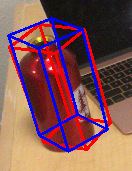

#### 7.31 迭代测试

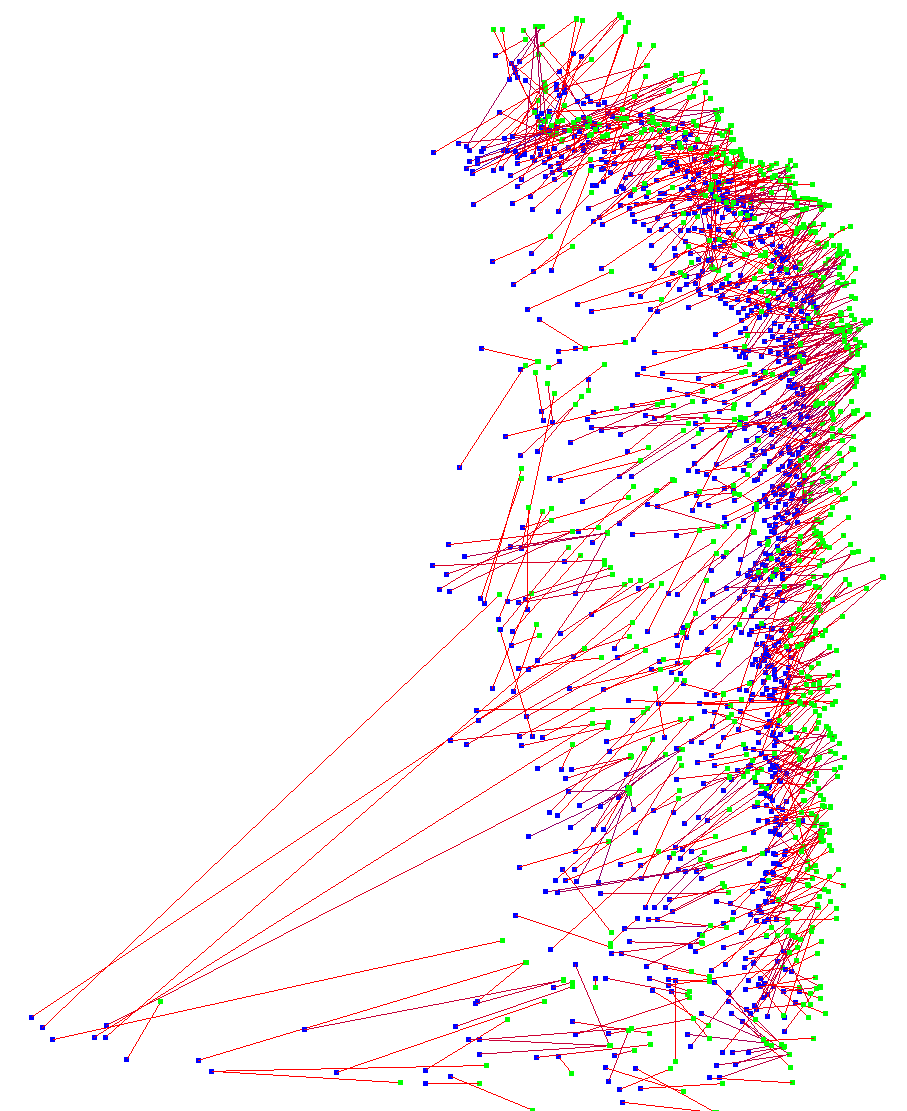

目前的lock_rate是99.5%, 已经达到迭代的退出条件。但是通过上图可以发现, 拖尾处的点依然是存在对应点的, 其匹配并没有被删除掉。

对于lock状态的行, 通过点对的距离进行过滤。

使用V_matrix选择perm_matrix中的点, 查看权重的分布。

图片:

也并非权重越大越好, 如下图, 权重最大的点是拖尾点。红色点是目标点和加权生成点, 图中这两个红色点组中的点对是所有现存点对中权重最大的。但是不妨碍其是拖尾点。

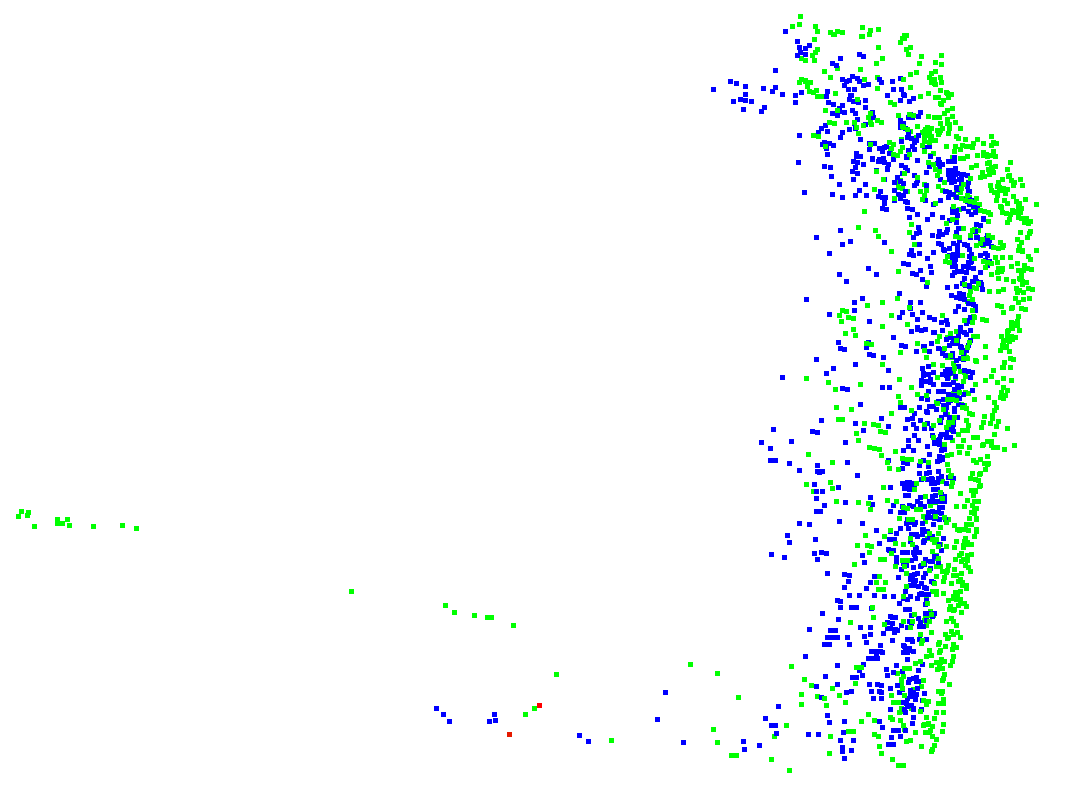

下图, 蓝色为绿色(原点云)中参与加权的点, 红色点为最终生成点。也符合条件(a.加权点与最终点相近, b.加权生成点与目标点相近)

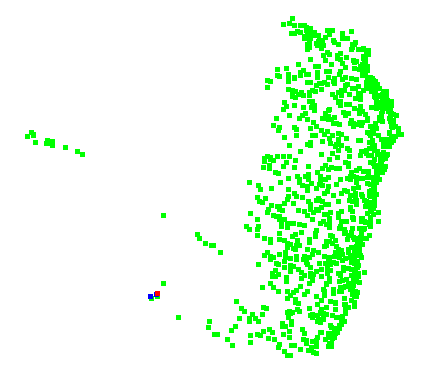

这种情况没有其他的信息应该是无法解决了, 寄希望于额外的背景点去除模块和SAM更精准的分割结果吧.

**更新base问题:**
深蓝色为迭代后结果, 红色为ground truth, 此时的在sym设置下的旋转误差为0.0, 在检定是否更新base帧, 如检查位姿旋转超过一定程度时, 应该使用sym下的位姿还是no_sym下的位姿?

**另一个重要的问题: 当更新base的之后, 应当想办法去掉拖尾**

In [ ]:
iter: 16
nrm result [cmp]
sdiff: 7.450580596923828e-08
tdiff: 0.009612576104700565
rdiff: 19.826547622680664
iter 16 result
sdiff: 7.450580596923828e-08
tdiff: 0.007756343577057123
rdiff:   0.0

1.is_base_frame中更新last_frame_one_stage, 测试使用相邻帧结果而非1+2model结果

2.新的base更新策略, 当rotation, translation 某一个超过阈值时

3.base去拖尾策略, 测试SAM

4.对于新添加的base帧与此前的base帧进行BA

5.recon model

**max_rate = 0.9**设置的有些不太合理, 因为lock rate基本都是突然变化的, 说明大部分点都是在一个阶段被突然过滤得只剩几个

在当前帧完成之后, 下一帧匹配的时候, 是否要将当前帧在加权时候没有用到的点删除掉？

先可视化没有用到的点, 看看是不是拖尾

在序列上, 比较 1-m 与 1+2m 的误差, 当两者估计的误差超过一定程度时候, 更新base帧。

在离base帧近的序列上, 1-m的结果更好, 尤其是每个序列刚刚开始的几帧

当离base逐渐远的时候, 1-m的结果受到累计误差的影响, 精度会逐渐降低, 此时1+2m的结果往往会更好, 但是到一定程度时, 也会变差。

目前在更新base后, one-stage和nrm的结果会突然变差,

In [ ]:
# 第20帧更新base
2023-08-01 08:06:10,546 : ================
2023-08-01 08:06:10,546 : final nrm (sym):
2023-08-01 08:06:10,546 : sdiff:   0.0
2023-08-01 08:06:10,546 : tdiff: 0.0072980644181370735
2023-08-01 08:06:10,546 : rdiff: 4.954008102416992
2023-08-01 08:06:10,546 : final color (sym):
2023-08-01 08:06:10,546 : sdiff:   0.0
2023-08-01 08:06:10,546 : tdiff: 0.0072980644181370735
2023-08-01 08:06:10,546 : rdiff: 4.954008102416992
2023-08-01 08:06:10,546 : final color ws (sym):
2023-08-01 08:06:10,546 : sdiff:   0.0
2023-08-01 08:06:10,546 : tdiff: 0.03885536268353462
2023-08-01 08:06:10,546 : rdiff: 7.307826042175293
2023-08-01 08:06:10,546 : final feat one-stage (sym):
2023-08-01 08:06:10,547 : sdiff:   0.0
2023-08-01 08:06:10,547 : tdiff: 0.03885536268353462
2023-08-01 08:06:10,547 : rdiff: 7.307826042175293
2023-08-01 08:06:10,547 : final nrm iter (sym):
2023-08-01 08:06:10,547 : sdiff:   0.0
2023-08-01 08:06:10,547 : tdiff: 0.007054783869534731
2023-08-01 08:06:10,547 : rdiff: 3.3017966747283936

# 可以看到, iter将要作为base帧的旋转误差从nrm的4.95降低到了3.30
# 然后下一帧开始, 不论是nrm还是one-stage(也就是1-m). 旋转误差都上升到了7度


# 更新base后
2023-08-01 08:06:11,073 : ================
2023-08-01 08:06:11,074 : final nrm (sym):
2023-08-01 08:06:11,074 : sdiff: 4.470348358154297e-08
2023-08-01 08:06:11,074 : tdiff: 0.00875033438205719
2023-08-01 08:06:11,074 : rdiff: 7.865816116333008
2023-08-01 08:06:11,074 : final color (sym):
2023-08-01 08:06:11,074 : sdiff: 4.470348358154297e-08
2023-08-01 08:06:11,074 : tdiff: 0.0077811055816709995
2023-08-01 08:06:11,074 : rdiff: 5.876131057739258
2023-08-01 08:06:11,074 : final color ws (sym):
2023-08-01 08:06:11,075 : sdiff: 4.470348358154297e-08
2023-08-01 08:06:11,075 : tdiff: 0.03829214721918106
2023-08-01 08:06:11,075 : rdiff: 7.283245086669922
2023-08-01 08:06:11,075 : final feat one-stage (sym):
2023-08-01 08:06:11,075 : sdiff: 4.470348358154297e-08
2023-08-01 08:06:11,075 : tdiff: 0.03829214721918106
2023-08-01 08:06:11,075 : rdiff: 7.283245086669922

检查新数据集上的对应pkl文件中gts与现在的是否相同

In [ ]:
transform
Out[105]:
array([[ 0.10979184, -0.00656042,  0.15937607, -0.37725848],
       [-0.08327124, -0.16738056,  0.05047442, -0.03517798],
       [ 0.13605024, -0.09715312, -0.09772216,  0.94389844],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],

gts['scales'][idx]
Out[106]: 0.19364405
gts['rotations'][idx]
Out[107]:
array([[ 0.5669776 , -0.03387877,  0.82303625],
       [-0.4300222 , -0.8643723 ,  0.2606557 ],
       [ 0.702579  , -0.5017098 , -0.5046484 ]], dtype=float32)
gts['translations'][idx]
Out[108]: array([-0.37725848, -0.03517798,  0.94389844], dtype=float32)

'/data1/jl/awsl-JL/object-deformnet-master/object-deformnet-master/data/Real/test/scene_2/0000'

# idx为2

绿色为观测点云, 红色为使用gt位姿变换后的nocs点云

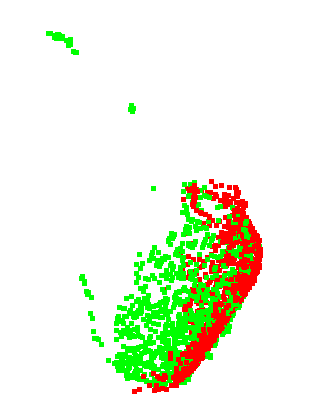

1. 检查新数据集下的pose

2. 运行一个train的debug, 检查是否也有这个问题

问题解决, 是seq_dataset中的rotation_canon, code来自SPD



---


在将seq_dataset中的rotation_canon取消之后, 重新训练了模型, 仅使用深度数据, 效果非常好.

但是之前迭代过程中, 需要迭代9次才能达标的lock_rate在这里仅仅一次就能完成, 说明其分布已经与之前不同了. 虽然是好事, 但是代码也需要进行修改, 不然会报错...

检查lock_rate的增长问题, 以及新模型对拖尾点的去除能力。目前来说去除得太过了.

In [ ]:
# 新模型不使用迭代, 仅1+2model, 在20帧上旋转误差仅2度以内

util frame: 19
resume_model 1+2 (color):
sdiff: 6.823163545277566e-08
tdiff: 0.0030456266831606627
rdiff: 0.2525162100791931
5deg5cm: 1.0
10deg10cm: 1.0
util frame: 19